# Geographical-based friendship network<!-- omit in toc-->

Luca Di Bello, University of Italian Switzerland (USI), 2023

## Table of contents<!-- omit in toc-->

- [Project description](#project-description)
- [Inhabitant maps](#inhabitant-maps)
  - [Purely random map](#purely-random-map)
  - [Geographical-based random map](#geographical-based-random-map)
  - [Friendship network](#friendship-network)

## Project description

Social networks are systems that map the relationships and interactions between individuals. Although social networks are typically dynamic, the focus of this project is put on a static example.

Geographical distance plays a crucial role in social network formation, with closer physical proximity typically leading to more frequent and stronger social ties.

Additionally, geographical features, such as the density of people in an area (more in cities and less in remote mountainous regions), profoundly influence the composition and scale of these networks, shaping the diversity and connectivity of communities within a given region.

## Inhabitant maps

The project features two kinds of inhabitant maps:

### Purely random map

1000 inhabitants are randomly distributed across a unit square map, $[0,1]^2$. Each individual is assigned a uniform random position $(x,y)$ in the map.

### Geographical-based random map

This map features several geographical areas $F$, such as cities, mountains, and lakes. The inhabitants are randomly distributed across the map, but the density of inhabitants is higher in cities and lower in mountains and lakes. The function $f$ maps the coordinates $(x, y)$ of an individual to the geographical area $f$ in which the individual is located.

$$
f(x,y) = \text{geographical area in which individual } (x,y) \text{ is located}
$$

In this map, individuals are no longer distributed uniformly at random across the map. Instead, the density of inhabitants depends on specific geographical features: each area has a positive factor that determines the ease of living there:

$$
\begin{equation*} \tag{1}
s_f = \text{ease of living in area } f \ \forall f \in F
\end{equation*}
$$

The probability of a random individual being located in coordinates $(x,y)$ is the following:

$$
\begin{equation} \tag{2}
P(\text{random person settles in } (x,y)) = \frac{s_{f(x,y)}}{\sum_{(x',y') \in \text{Map}} s_{f(x',y')}}
\end{equation}
$$

## Friendship network

From the inhabitant maps, a friendship network is created following two different models:

**Map 1 - Erdős–Rényi model**: The friendships are modeled as an *Erdős–Rényi* random graph. Each individual has a probability $p$ of being friends with another individual, and this probability $p$ is identical for all possible pairs of individuals

**Map 2 - Geographical model**: The probability of a friendship between two individuals A and B is modeled as follows:

$$
\begin{equation*} \tag{3}
P(A - B) = e^{-\beta d(A,B)}
\end{equation*}
$$

Where $d(A,B)$ is the Euclidean distance between $A$ and $B$.


## Implementation


In [1]:
# Import required packages for data manipulation and analysis
import pandas as pd
import numpy as np
import igraph as ig
import seaborn as sns
from scipy import stats

# Set matplotlib backend to inline (prints figures to the notebook)
%matplotlib inline

# Import packages for visualization
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.axes import Axes
from matplotlib.patches import Rectangle
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D

# Import custom utility module
import utility as util

# Import types
from typing import Tuple

> **Note:** The code documentation follows the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html).


$\textcolor{red}{\text{FIXME: Change DEV flag to False!}}$ 

In [2]:
# --- Development flag ---
# Set to True to run the notebook in development mode.
# This will run certain memory-intensive operations on a subset of the data / smaller parameters to speed up development.
DEV = True

### Scenario 1


#### A - Design for the random inhabitant map and friendship network

##### A.1 - Sampling individuals

The function `sample_uniform_random_individuals` samples $n$ individuals randomly from a unit square map $[0,1]^2$.

Pseudocode:

```
function sample_uniform_random_individuals(n):
    individuals <- []
    for each individual i = 1,2,....n:
        x <- Uniform(0,1)
        y <- Uniform(0,1)
        individuals <- individuals UNION {(x,y)}
    end for
    return individuals
end function
```


In [3]:
def sample_uniform_random_individuals(n=1000) -> np.ndarray:
  """
  Randomly sample n individuals from a uniform distribution.

  Args:
    n (int): Number of individuals to sample

  Returns:
    np.array: Array of tuples containing x and y coordinates of sampled individuals
  """
  # Generate n uniform random numbers for x and y coordinates
  x = np.random.uniform(0,1,size=n)
  y = np.random.uniform(0,1,size=n)

  # Save invididual coordinates as a tuple
  return np.array(list(zip(x, y)))

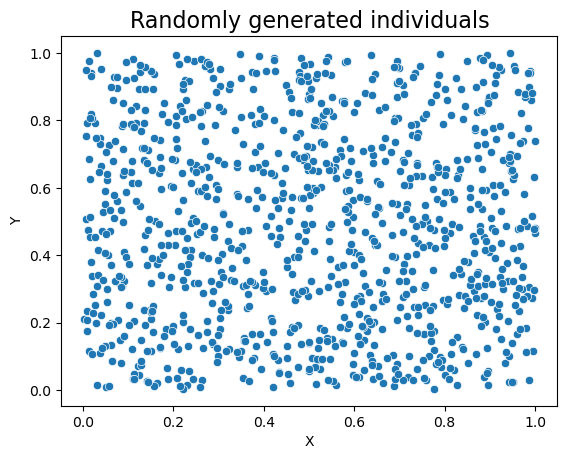

In [4]:
# Convert list to numpy array
individuals = sample_uniform_random_individuals()

# Print the first 10 individuals
plt.figure()
sns.scatterplot(x = individuals[:, 0], y = individuals[:, 1])
plt.title('Randomly generated individuals').set_fontsize('16')
plt.xlabel('X')
plt.ylabel('Y')

# Show the plot
plt.show()

##### A.2 - The `euclDistMatrix` function

The function `euclDistMatrix` computes the Euclidean distance between all pairs of individuals in a given map. The Euclidean distance between two individuals $i$ and $j$ is defined as follows:

$$
d(i,j) = \sqrt{(x_i - x_j)^2 + (y_i - y_j)^2}
$$

Pseudocode:

```
function euclDistMatrix(individuals):
    distMatrix <- NxN matrix of zeros (where N = |individuals|)
    for each individual i in individuals:
        for each individual j in individuals:
            distMatrix[i,j] <- sqrt((x_i - x_j)^2 + (y_i - y_j)^2)
        end for
    end for
    return distMatrix
end function
```


In [5]:
def euclDistMatrix(individuals: np.ndarray) -> np.ndarray:
  '''
  Creates a n x n matrix of Euclidean distances between n individuals

  Args:
    individuals (np.ndarray): Array of tuples containing x and y coordinates of individuals

  Returns:
    np.ndarray: n x n matrix of Euclidean distances between n individuals
  '''

  # Create an empty n x n matrix
  distMatrix = np.zeros((individuals.shape[0], individuals.shape[0]))

  # Loop over all individuals
  for i in range(individuals.shape[0]):
    # Loop over all individuals again
    for j in range(individuals.shape[0]):
      if i == j:
        continue # Distance between individual i and itself is 0 so we can skip this iteration
      else:
        # Calculate Euclidean distance between individual i and j
        distMatrix[i, j] = np.sqrt((individuals[i][0] - individuals[j][0])**2 + (individuals[i][1] - individuals[j][1])**2)
  return distMatrix

##### A.3 - The `distMatrixFromN` function

The function `distMatrixFromN`, given a number $n$ of individuals, performs the following steps 100 times:

1. Sample $n$ individuals randomly from a unit square map $[0,1]^2$.
2. Compute the Euclidean distance between all pairs of individuals in the map.
3. Computes summary information for the distance matrix such as the minimum, maximum, mean, median, and standard deviation of the distances.

For each of the summary statistics, the function returns a list of 100 values.

Pseudocode:

```
function distMatrixFromN(n)
    # Empty vectors to store statistics
    minDistances <- []
    maxDistances <- []
    meanDistances <- []
    medianDistances <- []
    stdDistances <- []

    # Execute 100 simulations
    for i in {1,2,...,100}:
        # Sample n individuals function defined in point A.1
        individuals <- sample_uniform_random_individuals(n)
        distMatrix <- euclDistMatrix(individuals)
        minDistances <- minDistances UNION {min(distMatrix)}
        maxDistances <- maxDistances UNION {max(distMatrix)}
        meanDistances <- meanDistances UNION {mean(distMatrix)}
        medianDistances <- medianDistances UNION {median(distMatrix)}
        stdDistances <- stdDistances UNION {std(distMatrix)}
    end for
    return minDistances, maxDistances, meanDistances, medianDistances, stdDistances
end function
```


In [6]:
def distMatrixFromN(n: int, n_simulations=100) -> pd.DataFrame:
  '''
  This function simulates *n_simulation* times (by default 100) the generation of n individuals and
  computes the minimum, maximum, mean, median and standard deviation of the distances on each of them.

  Args:
    n (int): Number of individuals to sample per simulation.
    n_simulations (int): Number of simulations to run. Default is 100.

  Returns:
    pd.DataFrame: DataFrame containing 100 rows, each of them contains the computed statistics.
  '''

  # Empty list to store statistics
  minDistances = np.zeros(n_simulations)
  maxDistances = np.zeros(n_simulations)
  meanDistances = np.zeros(n_simulations)
  medianDistances = np.zeros(n_simulations)
  stdDistances = np.zeros(n_simulations)

  # Run the experiment 100 times
  for i in range(n_simulations):
    # Sample N individuals
    individuals = sample_uniform_random_individuals(n)
    # Compute distances between sampled individuals
    distMatrix = euclDistMatrix(individuals)

    # Extract upper triangular matrix without diagonal
    # - Distances between individuals are symmetric
    # - On the diagonal we have only zeros
    upper_triangle_indices = np.triu_indices(n, k=1)
    distMatrix = distMatrix[upper_triangle_indices]

    # Compute + save statistics
    minDistances[i] = np.min(distMatrix)
    maxDistances[i] = np.max(distMatrix)
    meanDistances[i] = np.mean(distMatrix)
    medianDistances[i] = np.median(distMatrix)
    stdDistances[i] = np.std(distMatrix)

  # Create pandas DataFrame
  return pd.DataFrame({'minDistances': minDistances, 'maxDistances': maxDistances, 'meanDistances': meanDistances, 'medianDistances': medianDistances, 'stdDistances': stdDistances})

In [7]:
# Example
distMatrixFromN(10)

,minDistances,maxDistances,meanDistances,medianDistances,stdDistances
0,0.039756,1.212059,0.619628,0.619749,0.267823
1,0.094591,1.102927,0.559399,0.577470,0.239720
2,0.128504,1.008388,0.482346,0.417891,0.238085
3,0.092392,1.166191,0.527710,0.526371,0.278612
4,0.046044,1.192421,0.668025,0.712283,0.293227
...,...,...,...,...,...
95,0.187824,1.036153,0.538184,0.552327,0.221466
96,0.015233,1.044931,0.475273,0.532256,0.240246
97,0.054581,0.909739,0.528625,0.549464,0.227985
98,0.107457,1.018490,0.553662,0.489914,0.243900


##### A.4 - The `erdosRenyiFromP` function

The function `erdosRenyiFromP` generates an Erdős–Rényi graph given the number of individuals $n$ and the probability $p$ of an edge between a couple of nodes.

Pseudocode:

```
function erdosRenyiFromP(n, p)
  adjency_matrix = N x N matrix of zeros (where N = n)

  # Cycle through each individual
  for individual i in {1,2,...n}
    for individual j in {i+1,i+2,...,n-1}
      # Bernoulli simulation with probability p of positive outcome (having an edge between i and j)
      if (uniform(0,1) < p)
        # Since the graph is undirected we need to set the edge between i and j and between j and i
        adjacency_matrix[i, j] = 1
        adjacency_matrix[j, i] = 1
      end if
    end for
  end for

  # Return adjency matrix
  return adjency_matrix

end function
```


#### B - Exploring alternative modeling approaches

##### B.1 - Exploring n

In this section will be explored the minimum, maximum and mean Euclidean distance on a randomly generated population of size $n$, analyzing the data with different sizes: 10, 100, 1000, 10000.

The simulations will be run using function `distMatrixFromN` defined earlier in point *A.3* to gather statistics on the Euclidean distance between all pairs of individuals in a given map.

> Note: the number of simulation run for each value of $n$ has been set to 5 rather than 100 to speed up the execution of this task. With the default value the simulation would take several minutes to complete (estimated time for n=10000: ~50 minutes).


In [8]:
import time

ns = [10,100,1000,10000] if not DEV else [10,30,50,100]
n_simulations = 5

# Run simulations with different sizes
results: list[pd.DataFrame] = []
for n in ns:
  print("Running simulation for n = {}".format(n))
  # Save start time
  start = time.time()
  result = distMatrixFromN(
    n,
    n_simulations=n_simulations # Reduce number of simulations to 5 (too memory intensive otherwise)
  )
  print("\t-took {} seconds".format(np.round(time.time() - start, 2)))

  # Compute simulation + save result
  results.append(result)

Running simulation for n = 10
	-took 0.0 seconds
Running simulation for n = 30
	-took 0.01 seconds
Running simulation for n = 50
	-took 0.01 seconds
Running simulation for n = 100
	-took 0.06 seconds


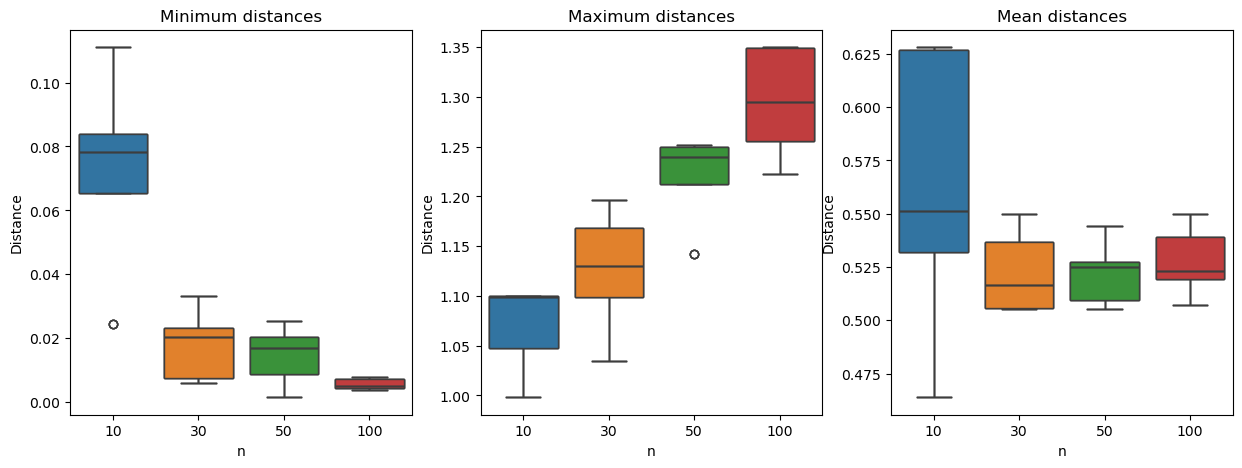

In [9]:
# Extract min, max, mean distances from results
minDistances = [result['minDistances'].values for result in results]
maxDistances = [result['maxDistances'].values for result in results]
meanDistances = [result['meanDistances'].values for result in results]

# Three plots side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Set tick and labels for all subplots
for ax in axes:
  ax.set_xticks(range(len(ns)))
  ax.set_xticklabels(ns)
  ax.set_xlabel('n')
  ax.set_ylabel('Distance')

# Plot min / max / mean distances distances for different n
for _ in range(len(ns)):
  # Plot min distances
  sns.boxplot(data=minDistances, ax=axes[0])
  axes[0].set_title('Minimum distances')

  # Plot max distances
  sns.boxplot(data=maxDistances, ax=axes[1])
  axes[1].set_title('Maximum distances')

  # Plot mean distances
  sns.boxplot(data=meanDistances, ax=axes[2])
  axes[2].set_title('Mean distances')

# Show the plot
plt.show()

From the generated plots, it is possible to note the following trends:

- The minimum distance tends to decrease when $n$ increases. This behavior is expected, as the probability of having points closer to each other is proportional to the number of uniformly generated samples.

- The maximum distance tends to increase when $n$ increases. For the same reasons as above, the probability of two points being far from each other increases. The maximum distance will tend to $\sqrt{2}$, as the maximum distance between two points in a unit square is the diagonal of the square.

- The average distance tends to decrease when $n$ increases. Also, this behavior is expected, as the population density increases, the average distance between two points decreases.


##### B.2 - Exploring p

In this section will be explored characteristics of the Erdős–Rényi graph generated with probabilities $p$ of an edge between a couple of nodes, analyzing the data with different values of $p$: 0.1, 0.2, 0.3, 0.4, 0.5.


In [10]:
# Generate random graph
ps = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9]

# Run simulations with different probabilities
n_individuals = 1000
graphs = [(p, ig.Graph.Erdos_Renyi(n=n_individuals, p=p, directed=False, loops=False)) for p in ps]

**Degree distribution**

In this subsection will be explored the degree distribution of a randomly generated population of size $n=1000$, analyzing the data with different probabilities.


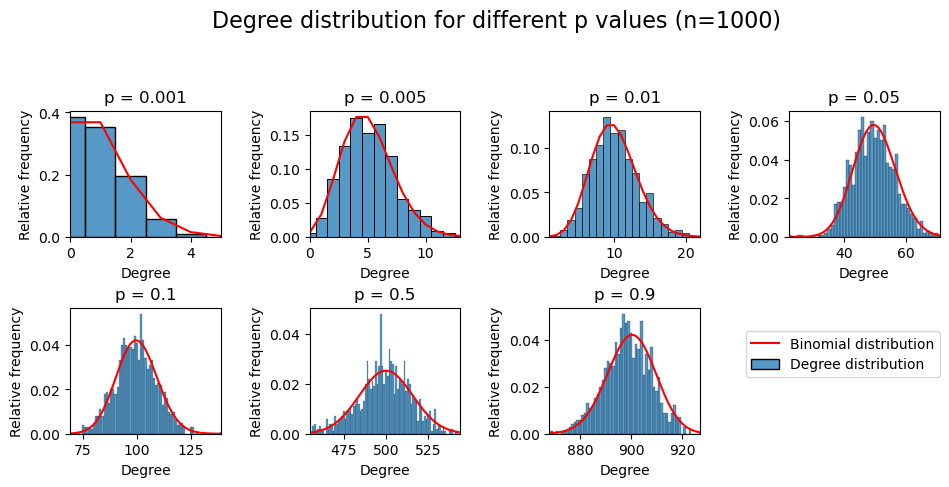

In [11]:
# Plot degree distribution
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

# Set title for entire figure
fig.suptitle(f'Degree distribution for different p values (n={n_individuals})', fontsize=16)

# Add space between subplots
fig.tight_layout(pad=3.0)

# Compute degree distribution for each p
prob_degrees = []
for p in ps:
  prob_degrees.append(stats.binom.pmf(np.arange(0, 1000), n=1000, p=p))

for i, tuple in enumerate(graphs):
  p, graph = tuple
  ax = axs[i//4, i%4]
  degrees = graph.degree()
  series = pd.Series(degrees)

  # Plot degree distribution as histogram
  sns.histplot(series, label='Degree distribution', ax=ax, stat='probability', discrete=True)
  
  # Plot binomial distribution on top of histogram
  ax.plot(np.arange(0, 1000), prob_degrees[i], label='Binomial distribution', color='red')

  # Zoom in on x axis
  ax.set_xlim(min(degrees), max(degrees))

  # Vertical offset to avoid overlapping
  ax.set_title('p = {}'.format(ps[i]))
  ax.set_xlabel('Degree')
  ax.set_ylabel('Relative frequency')

# Hide extra subplots
for i in range(len(ps), 2 * 4):
  axs[i//4, i%4].axis('off')

# Create custom legend to not cover the plots
fig.legend(['Binomial distribution', 'Degree distribution'], loc='upper right', bbox_to_anchor=(0.95, 0.35))

# Plot figure
plt.show()

From the histogram of the degree distribution (see figure below), it is possible to note that, the more the probability $p$ of having an edge between two nodes increases, the more the degree distribution tends to a Binomial distribution.

This behavior is expected as the Erdős–Rényi graph consists of a series of Bernoulli trials, where each edge has a probability $p$ of being created.

**Adajency matrix structure and average path length**

In this section the adajency matrices of a randomly generated population of size $n=1000$ will be explored, analyzing its structure with different probabilities.


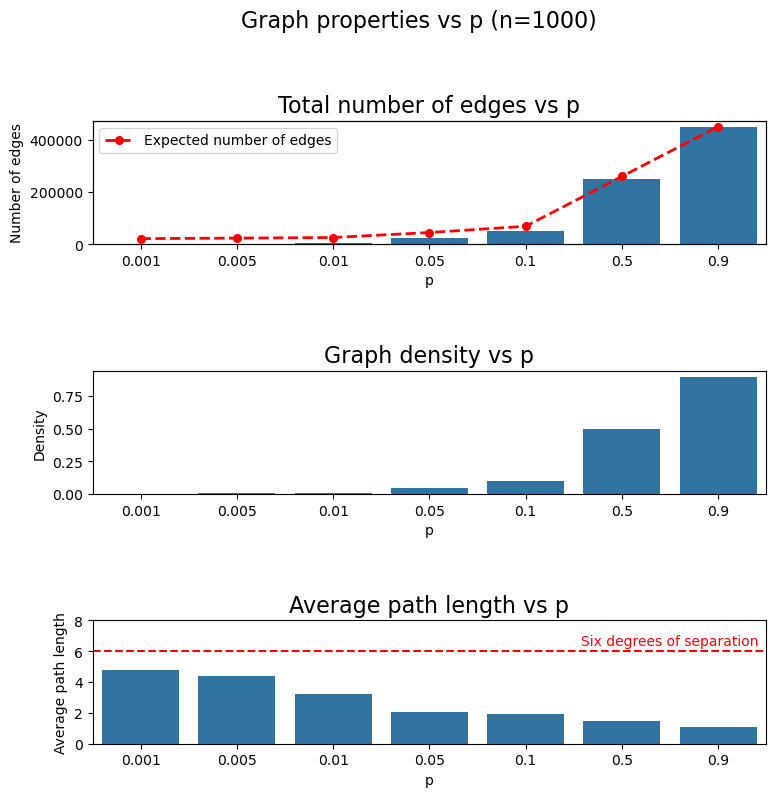

In [12]:
def expectedNumberOfEdges(n: int, p: float) -> float:
  '''
  Computes the expected number of edges in a random graph with n nodes and p probability of edge creation.

  Args:
    n (int): Number of nodes
    p (float): Probability of edge creation

  Returns:
    float: Expected number of edges in a random graph with n nodes and p probability of edge creation
  '''
  return n * (n - 1) / 2 * p

# Create pandas DataFrame
df = pd.DataFrame([
  {
    'p': p,
    'total_edges': graph.ecount(),
    'density': graph.density(),
    'average_degree': np.mean(graph.degree()),
    'average_path_length': graph.average_path_length()
  } for p, graph in graphs])

# Plot total edges, density and average degree
fig, ax = plt.subplots(3, 1, figsize=(8, 8))

# Set subplot title
fig.suptitle(f'Graph properties vs p (n={n_individuals})', y=1, fontsize=16)

# Add space between subplots
fig.tight_layout(pad=3, h_pad=7.0)

def plotHistogram(ax, data, title, ylabel):
  # Plot histogram
  sns.barplot(x='p', y=data, data=df, ax=ax)
  ax.set_title(title).set_fontsize('16')
  ax.set_xlabel('p')
  ax.set_ylabel(ylabel)

# Plot histograms for total edges on top of expected number of edges
plotHistogram(ax[0], 'total_edges', 'Total number of edges vs p', 'Number of edges')

# Plot line and treat X axis as categorical (same scale as barplot)
twin = ax[0].twinx()
twin.set_yticks([])
sns.pointplot(x='p', y=[expectedNumberOfEdges(1000, p) for p in ps], data=df, ax=twin, color='red', linestyles='--', label='Expected number of edges', linewidth=2)
twin.legend(loc='upper left')

# Plot histograms for density
plotHistogram(ax[1], 'density', 'Graph density vs p', 'Density')

# Plot histograms for average path length
plotHistogram(ax[2], 'average_path_length', 'Average path length vs p', 'Average path length')

# Highlight the average path length = 6 line (six-degree of separation)
ax[2].axhline(6, color='red', linestyle='--')
ax[2].text(5.5, 6.2, 'Six degrees of separation', ha='center', va='bottom', color='red')

# Increase y axis length
ax[2].set_ylim(0, 8)

# Show figure
plt.show()

From the three graphs above, it is possible to note that, the more the probability $p$ of having an edge between two nodes increases, the more the graph tends to be connected, leading to a more dense adjacency matrix and an higher total number of edges.

It is also possible to see that the average path length tends to decrease when $p$ increases, as the graph will be more connected, meaning that the average distance between two nodes becomes smaller. This behavior is expected, as the density of the graph increases, each node will have more neighbors, leading to a smaller average distance between any two individuals.
When $p \rightarrow 1$, also the average path length tends to 1, as the graph is more and more connected. The average path length converges to 1 since each node will have a direct connection with all the other nodes (complete graph).

In conclusion, is possible to highlight that the *six-degree of separation* paradox is present in the Erdős–Rényi model, as the average path length is always smaller than 6, even when $p$ is extremely small. Learn more [here](https://en.wikipedia.org/wiki/Six_degrees_of_separation).

**Eigenvalues and degrees**

In this section will be explored the relationship between eigenvalues and degrees of a randomly generated population of size $n=1000$, analyzing the data with different probabilities.

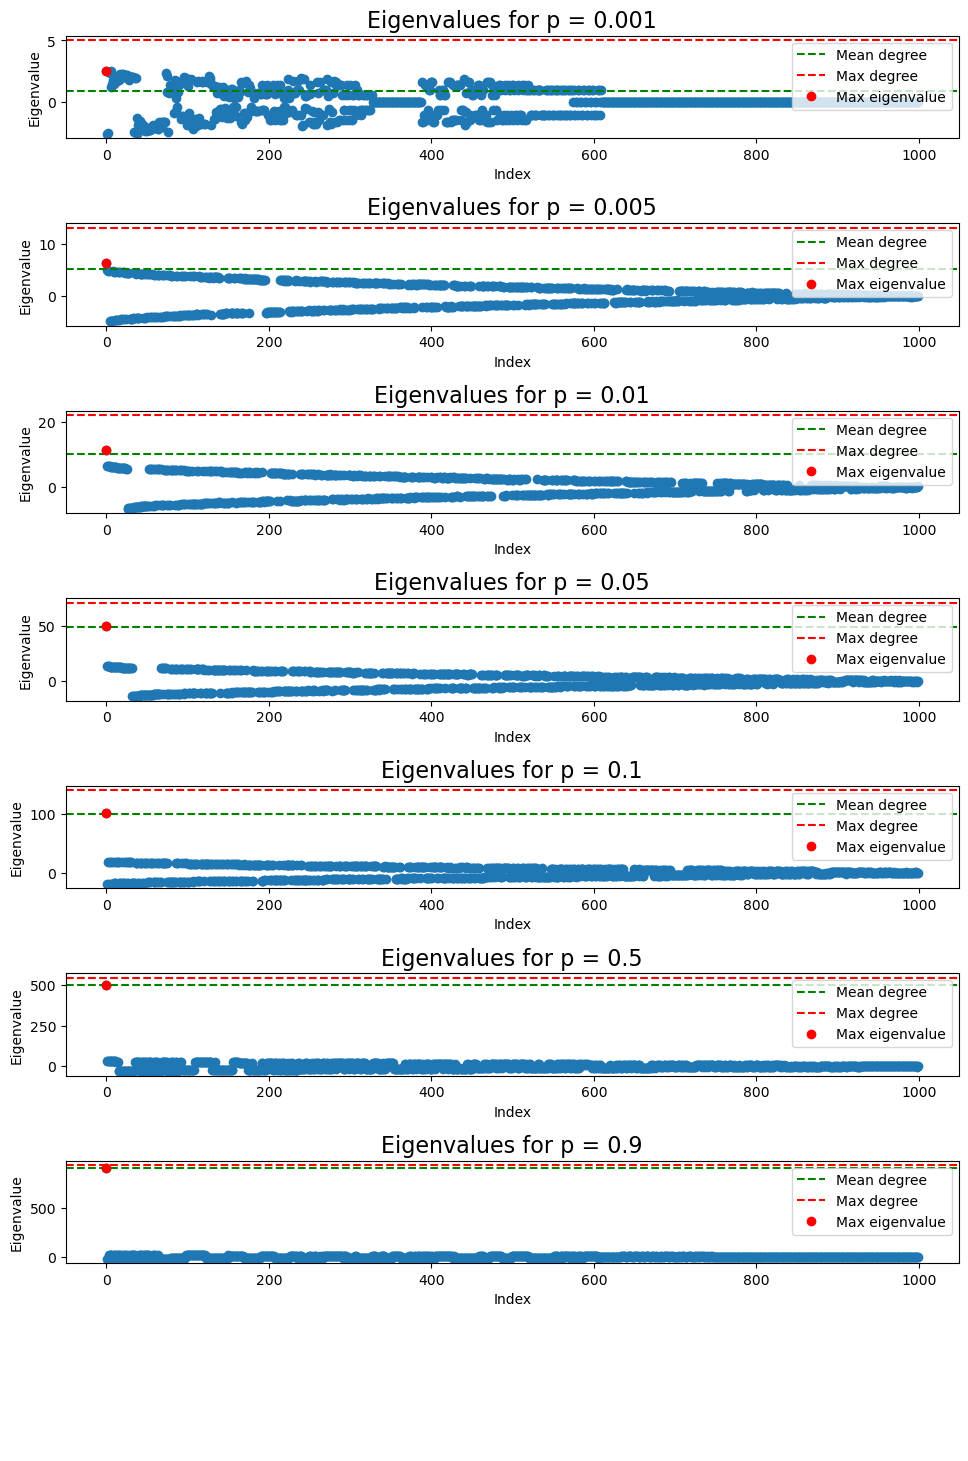

In [13]:
# Create subplots for eigenvalues + add space between subplots
fig, axes = plt.subplots(8, 1, figsize=(10, 15))
fig.tight_layout(pad=2.0, h_pad=4.0)

# Loop over graphs
for i, tuple in enumerate(graphs):
  # Unpack tuple
  p, graph = tuple

  # Compute eigenvalues and eigenvectors
  eigenvalues, eigenvectors = np.linalg.eig(graph.get_adjacency().data)

  # Take only real part of eigenvalues
  eigenvalues = eigenvalues.real

  # Find mean and max degree
  degrees = np.array(graph.degree())
  mean_degree = degrees.mean()
  max_degree = degrees.max()

  # Plot eigenvalues
  ax = axes[i]
  ax.plot(eigenvalues, 'o')
  ax.set_title('Eigenvalues for p = {}'.format(p)).set_fontsize(16)
  ax.set_xlabel('Index')
  ax.set_ylabel('Eigenvalue')

  # Add horizontal lines for mean and max degree
  ax.axhline(mean_degree, color='green', linestyle='--', label='Mean degree')
  ax.axhline(max_degree, color='red', linestyle='--', label='Max degree')

  # Highligh max eigenvalue marker with red color
  max_eigenvalue = eigenvalues.max()
  ax.plot(np.where(eigenvalues == max_eigenvalue)[0], max_eigenvalue, 'o', color='red', label='Max eigenvalue')

  # Show legend on upper right corner
  ax.legend(loc='upper right')

# Hide extra subplots
for i in range(len(ps), 8):
  axes[i].axis('off')

# Show figure
plt.show()

From the plots above, is possible to note that the maximum eigenvalue is always greater than the average degree, and less than the maximum degree. Due to the increasing graph density, the gap between the maximum degree and average degree tends to decrease when $p$ increases.

If the graph is complete (i.e., with $p=1$), the maximum eigenvalue will be equal to the maximum degree.

**Connected components and eigendecomposition**

In this section will be explored the relationship between the largest connected component and the eigenvalus of a randomly generated population of size $n=1000$, analyzing the data with different probabilities.

From the Laplacian matrix of the graph, computed as $L = D - A$ where $D$ is the degree matrix and $A$ is the adjacency matrix, it is possible to acquire relevant information about the graph. In particular:

- The number of connected components in a graph equals the number of orthonormal eigenvectors associated with eigenvalue $\lambda = 0$ of the graph Laplacian.

- From the second smallest eigenvalue $\lambda_1$ of the Laplacian matrix of the graph, it is possible to estimate the size of the largest connected component of the graph:
- If $\lambda_1 <= 0$, then the graph is not fully connected, meaning that the largest connected component of the graph is smaller than the entire graph.
- If $\lambda_1 > 0$, the graph is fully connected, meaning that the largest connected component of the graph is the entire graph.

Sources:
- [The Smallest Eigenvalues of a Graph Laplacian (by Shriphani Palakodety)](http://blog.shriphani.com/2015/04/06/the-smallest-eigenvalues-of-a-graph-laplacian/)
- [Matrices and Graphs – Spectral Techniques](https://courses.cs.duke.edu/fall18/compsci531/lablectures)

In [14]:
n_connected_components = []
n_second_smallest_eigenvalues = []
for i, tuple in enumerate(graphs):
  p, graph = tuple

  # Compute laplacian matrix
  laplacian = graph.laplacian()
  # Compute eigenvalues and eigenvectors of laplacian matrix
  eigenvalues, eigenvectors = np.linalg.eig(laplacian)

  # Compute graph components
  components = graph.components()

  # Compute the total number of orthonormal eigenvectors associated with eigenvalue 0
  num_zero_eigenvectors = np.sum(np.isclose(eigenvalues, 0))

  # Find largest connected component of graph
  largest_component = components.giant()
  # Find the second smallest eigenvalue (Theorem: Fiedler vector)
  second_smallest_eigenvalue = np.sort(eigenvalues)[1]

  # Add data to lists
  n_connected_components.append(num_zero_eigenvectors)
  n_second_smallest_eigenvalues.append(second_smallest_eigenvalue)

  # Print analysis results
  print("p = {}".format(p))
  print("\t- Expected number of connected components = {}".format(num_zero_eigenvectors))
  print("\t- Actual number of connected components = {}".format(len(components)))
  print("\t- Second smallest eigenvalue = {}".format(second_smallest_eigenvalue))
  print("\t- Size of largest connected component = {}".format(largest_component.vcount()))

p = 0.001
	- Expected number of connected components = 522
	- Actual number of connected components = 522
	- Second smallest eigenvalue = (-1.7340214024617606e-15+4.103257191879996e-16j)
	- Size of largest connected component = 45
p = 0.005
	- Expected number of connected components = 6
	- Actual number of connected components = 6
	- Second smallest eigenvalue = 0.0
	- Size of largest connected component = 995
p = 0.01
	- Expected number of connected components = 1
	- Actual number of connected components = 1
	- Second smallest eigenvalue = 0.8201598103981061
	- Size of largest connected component = 1000
p = 0.05
	- Expected number of connected components = 1
	- Actual number of connected components = 1
	- Second smallest eigenvalue = 21.113979546989725
	- Size of largest connected component = 1000
p = 0.1
	- Expected number of connected components = 1
	- Actual number of connected components = 1
	- Second smallest eigenvalue = 66.73477360396416
	- Size of largest connected component =

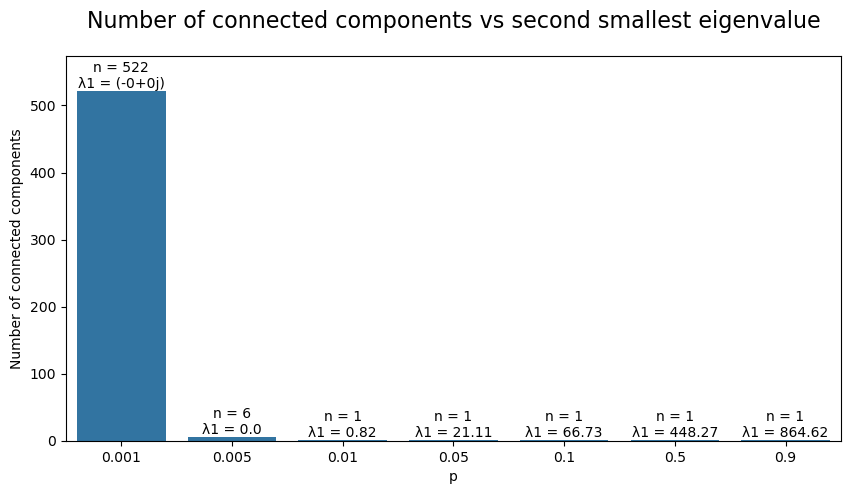

In [15]:
# Plot analysis results
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=ps, y=n_connected_components)
ax.set_title('Number of connected components vs second smallest eigenvalue', pad=20).set_fontsize('16')
ax.set_xlabel('p')
ax.set_ylabel('Number of connected components')
ax.set_ylim(0, 1.1 * max(n_connected_components)) # Add spacing between bars and plot border on y axis

# Add text showing the number of connected components + second smallest eigenvalue
for i in range(len(ps)):
  ax.text(i, n_connected_components[i], 'n = {}\nλ1 = {}'.format(n_connected_components[i], np.round(n_second_smallest_eigenvalues[i], 2)), ha='center', va='bottom')

# Show figure
plt.show()

#### C - Regarding the `erdosRenyiFromP` function for generating Friendship Networks

##### C.1 - Erdős–Rényi to model real-world friendship networks

Unfortunately, the Erdős–Rényi model is not suitable for modeling real-world friendship networks, as it takes into account only the probability of having an edge between two nodes, without considering many other factors that influence the formation of a friendship between two individuals in real life, such as their geographical distance.

##### C.2 - Advantages and disadvantages of the Erdős–Rényi model

To model a friendship network, the Erdős–Rényi model has the following advantages and disadvantages:

**Advantages**

1. *Simple*: the Erdős–Rényi model is simple to understand and implement It requires only the number of nodes (in this scenario, the number of individuals) and the probability of having an edge between two nodes (in this scenario, the probability of two individuals being friends).

2. *Randomness*: this model is random, meaning that it is possible to generate a completely different graph simply by re-running the simulation with the same parameters.

3. *Easy mathematical analysis*: it is possible to analyze the Erdős–Rényi model mathematically with ease (e.g. degree distribution, average path length, etc.).

**Disadvantages**

1. *Lack of realism*: as cited before, the Erdős–Rényi model is not suitable for modeling real-world friendship networks, as it does not take into account many important factors that influence the formation of a friendship between two individuals in real-life.

2. *The degree follows a binomial distribution*: the network degree distribution has a binomial distribution, meaning that the degree of the node is completely random. In real-world friendship networks, such a distribution is not realistic.

3. *Absence of clustering*: as partially explained in the previous point, the Erdős–Rényi model does not take into account the fact that in real-world friendship networks, the degree of a node is not random but follows a tendency where friends of a person are more likely to be friends with each other, creating dense clusters of nodes.

### Scenario 2


#### A - Design the pseudocode for the Geographical-based Random Inhabitant Map

##### A.1 - The `geographicalFeatureMap` function

This function generates a geographical feature map based on the list of geographical features $F$ and the list of geographical features' ease of living $s_f$. The function return a $N \times N$ matrix of zeros, where $N$ is the size of the map, and each cell of the matrix is filled with the geographical feature $f$ in which the cell is located.

The map is generated as follows:

- 1 circular desert (value = `Desert`)
- 1 elliptical mountain range (value = `Mountain`)
- 1 sinusoidal river (value = `River`)
- 4 squared cities (value = `City`)

Pseudocode:

```
function geographicalFeatureMap(n)
    # Initialize empty map
    map <- NxN matrix of zeros (where N = |map|)
    
    # Setup features sizes relative to map size
    circular_desert_radius <- round(n / factor_1)
    elliptic_mountain_radius_x <- round(n / factor_2)
    elliptic_mountain_radius_y <- round(n / factor_3)
    sinusoidal_river_amplitude <- round(n / factor_4)
    sinusoidal_river_period <- round(n / factor_5)
    square_city_side <- round(n / factor_6)
    
    # Define features centers relative to map size
    circular_desert_center <- (x, y)
    elliptic_mountain_center <- (x1, y1)
    sinusoidal_river_start <- (x2, y2)
    square_city1_center <- (x3, y3)
    square_city2_center <- (x4, y4)
    square_city3_center <- (x5, y5)

    # Cycle through each cell of the map
    for i in row cells
        for j in column cells:
            # Check if (i,j) is in a desert
            if (i,j) is inside Circle(radius = circular_desert_radius, center = circular_desert_center)
                map[i,j] <- Desert 
            end if
            # Check if (i,j) is in the mountain range
            if (i,j) is inside Ellipse(radius_x = elliptic_mountain_radius_x, radius_y = elliptic_mountain_radius_y, center = elliptic_mountain_center)
                map[i,j] <- Mountain
            end if
            # Check if (i,j) is inside the sinusoidal river
            if (i,j) is inside Sinusoid(amplitude = sinusoidal_river_amplitude, period = sinusoidal_river_period, start = sinusoidal_river_start)
                map[i,j] <- River
            end if
            # Check if point (i,j) is in one of the three cities
            for city in cities:
                if (i,j) is inside Square(side = square_city_side, center = city_center)
                    map[i,j] <- City            
                end if
            end for
        end for
    end for

    # Return map filled with geographical features
    return map
end function
```

In [16]:
def geographicalFeatureMap(n: int = 1000) -> np.ndarray:
  '''
  Creates a map of geographical features.

  Args:
    n (int): Size of the map

  Returns:
    np.ndarray: Map of geographical features
  '''

  # Check minimum map size
  if n < 8:
    raise ValueError("Map size must be at least 8x8")

  # Create empty map
  map = np.zeros((n, n))

  # Step 1: define geographical sizes

  ## Circular desert properties
  desert_radius = n // 4

  ## Elliptical mountain range properties
  mountain_radius_x = n // 8
  mountain_radius_y = n // 4 

  ## Sinusoidal river properties
  # Calculate the amplitude and period
  amplitude = n * 0.1
  period = n * 0.5
  river_midline = n // 6 # Midline of the river
  angle = np.pi / 4 # 45 degrees

  ## Square cities properties
  city_size = n // 5

  # Step 2: define geographical centers (Note: Top left corner of the map is (0, 0), bottom right corner is (n, n))

  ## Desert center is at the center of the map (slightly shifted to the left)
  desert_center = util.Point(x = n // 2 - desert_radius // 5, y = n // 2 - desert_radius // 3)

  ## Montain range on the right of the desert
  mountain_center = util.Point(x = n // 2 + desert_radius + mountain_radius_y // 2, y =  n // 2)

  ## Three cities: one in the bottom left corner, one in the top right corner and one under the desert (slightly shifted to the right)
  city_centers = [
    util.Point(x = 0, y =0),
    util.Point(x = n - city_size, y = 0),
    util.Point(x = 0, y = n - city_size),
    util.Point(x = n // 2 - desert_radius - city_size // 2, y = n // 2 - city_size // 2 + desert_radius)
  ]

  # Loop over all map coordinates and check if they are inside a specific geographical feature
  for i in range(n): # Y coordinate
    for j in range(n): # X coordinate
      # Add circle
      if (i - desert_center.y)**2 + (j - desert_center.x)**2 <= desert_radius**2:
        map[i, j] = util.GeographicalFeatureType.DESERT.value

      # Add mountain range
      if (i - mountain_center.y)**2 / mountain_radius_y**2 + (j - mountain_center.x)**2 / mountain_radius_x**2 <= 1:
        map[i, j] = util.GeographicalFeatureType.MOUNTAIN.value
      
      # Add cities
      for city_center in city_centers:
        if i >= city_center.y and i <= city_center.y + city_size and j >= city_center.x and j <= city_center.x + city_size:
          map[i, j] = util.GeographicalFeatureType.CITY.value

      # Calculate the left and right bounds of the river relative to the midline
      rotated_i = int((i - river_midline) * np.cos(angle) - (j - river_midline) * np.sin(angle)) + river_midline
      rotated_j = int((i - river_midline) * np.sin(angle) + (j - river_midline) * np.cos(angle)) + river_midline

      river_left_bound = amplitude * np.sin(2 * np.pi * rotated_j / period) + river_midline * 0.5
      river_right_bound = river_midline + amplitude * np.sin(2 * np.pi * rotated_j / period)

      # Check if the current point is within the river bounds
      if rotated_i >= river_left_bound and rotated_i <= river_right_bound:
          map[i, j] = util.GeographicalFeatureType.RIVER.value

  # Return map
  return map

In [17]:
# Example ease of living values for the geographical features
ease_of_living_values = np.array([150, 20, 30, 250, 850])

# Normalize the ease of living values
normalized_ease_of_living = ease_of_living_values / ease_of_living_values.sum()

# Create default map settings
DEFAULT_GEO_MAP_SETTINGS = util.GeographicalMapSettings([
  # Woods can be habitable but less so than cities
  util.GeographicalFeature(util.GeographicalFeatureType.WILDERNESS,    'Wilderness',      'green',  ease_of_living=np.double(normalized_ease_of_living[0])),
  # Desert is harsh with minimal ease of living
  util.GeographicalFeature(util.GeographicalFeatureType.DESERT,   'Desert',     'yellow', ease_of_living=np.double(normalized_ease_of_living[1])),
  # Mountain living is tough due to terrain
  util.GeographicalFeature(util.GeographicalFeatureType.MOUNTAIN, 'Mountains',  'brown',  ease_of_living=np.double(normalized_ease_of_living[2])),
  # River areas can be fertile and more habitable
  util.GeographicalFeature(util.GeographicalFeatureType.RIVER,    'River',      'blue',   ease_of_living=np.double(normalized_ease_of_living[3])),
  # Cities have the highest ease of living
  util.GeographicalFeature(util.GeographicalFeatureType.CITY,     'City',       'gray',   ease_of_living=np.double(normalized_ease_of_living[4])),
], size=1000)

def plotGeographicalMap(
    geographical_map: np.ndarray,
    mapSettings: util.GeographicalMapSettings = DEFAULT_GEO_MAP_SETTINGS,
    ax: Axes | None = None,
    show_legend: bool = True
) -> Axes:
  '''
  Plots a geographical map.

  Args:
    mapSettings (ut.GeographicalMapSettings): Map settings
    ax (plt.Axes): Axes to plot the map on

  Returns:
    plt.Axes: Axes containing the geographical map
  '''

  # Create custom color palette from map settings
  palette = sns.color_palette([feature.color for feature in mapSettings.features])

  # Display map with a heatmap
  ax = sns.heatmap(geographical_map, cmap=palette, cbar=False, ax=ax)

  # Steps every 50 ticks
  ticks = np.arange(0, geographical_map.shape[0]+50, 50)
  # Add ticks to the plot
  ax.set_xticks(ticks)
  ax.set_yticks(ticks)
  ax.set_xticklabels(ticks)
  ax.set_yticklabels(ticks)

  # Set plot title, x and y labels
  ax.set_title('Geographical map', pad=20).set_fontsize('16')
  ax.set_xlabel('X coordinate')
  ax.set_ylabel('Y coordinate')

  if show_legend:
    # Add custom legend
    legend_elements = [Rectangle((0,0),1,1,fc=feature.color, label=f"{feature.name} [factor={round(feature.ease_of_living, 3)}]") for feature in mapSettings.features]
    # Create legend from custom artist/label lists on the side of the plot (not on top)
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.5, 1.0))
    # Fit legend to plot
    plt.tight_layout()

  # Return plot figure
  return ax

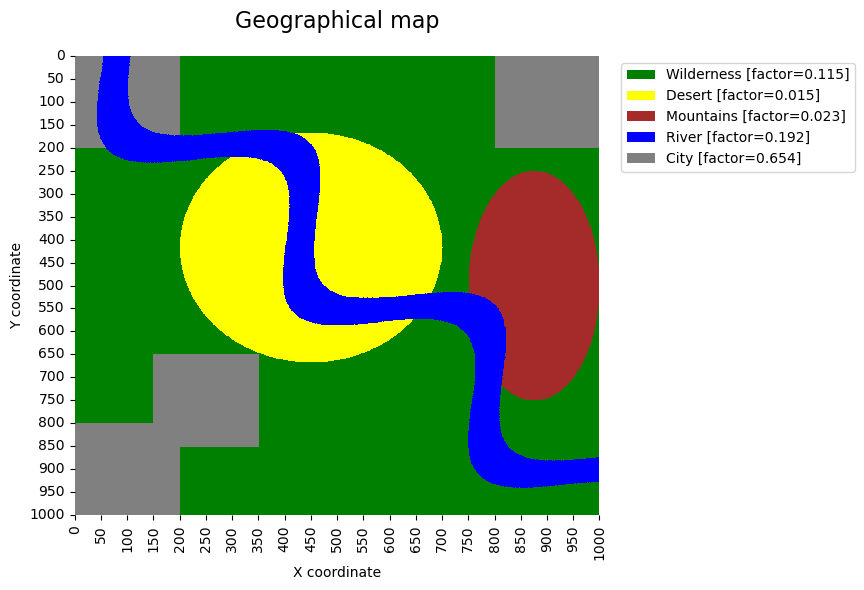

In [18]:
# Generate geographical feature map
GEO_MAP = geographicalFeatureMap(DEFAULT_GEO_MAP_SETTINGS.size)

# Generate and show geographical map
plt.figure(figsize=(10, 6))
plotGeographicalMap(GEO_MAP, show_legend=True)
plt.show()

##### A.2 - The `geographicalFeatureProbability` function

This function computes the probability of a random individual being located in coordinates $(x,y)$ of the map generated with the function `geographicalFeatureMap`. It assigns a probability to each coordinate $(x,y)$ of the map, based on the geographical feature $f$ in which the coordinate is located.

Pseudocode:

```
function geographicalFeatureMap()
  # Generate geographical map of size N x N
  geo_map <- geographicalFeatureMap()

  # Initialize empty probability map
  prob_map <- NxN matrix of zeros (where N = same size of geo_map)

  # Compute the total ease of living factor of the map
  total_ease_of_living <- sum(s_f(x,y) for each cell (x,y) of geo_map)

  # Compute equation 2 for each cell of the map
  for y in row cells
    for x in column cells:
      
      # Get feature in which (x,y) is located
      f_xy <- geo_map[y,x]

      # Now, get the ease of living factor of the feature in which (x,y) is located
      s_f_xy <- ease of living factor of f_xy

      # Now, compute equation 2 for the cell (x,y)
      prob_map[y,x] <- s_f_xy / total_ease_of_living
    end for
  end for

  # Return the probability map
  return prob_map

end function
```

In [19]:
def getCoordinateFeature(geographical_map: np.ndarray, x: int, y: int, map_settings: util.GeographicalMapSettings = DEFAULT_GEO_MAP_SETTINGS) -> util.GeographicalFeature:
    '''
    Returns the geographical feature at the given coordinates.

    Args:
      i (int): Y coordinate
      j (int): X coordinate

    Returns:
      GeographicalFeature: Geographical feature at the given coordinates
    '''
    return map_settings.features[int(geographical_map[y, x])]


def geographicalFeatureProbability (geographical_map: np.ndarray, map_settings: util.GeographicalMapSettings = DEFAULT_GEO_MAP_SETTINGS) -> np.ndarray:
  '''
  Assigns a value of probability to each point in the grid, following equation 1 and 2 (see report).

  Returns:
    np.ndarray: Matrix of probabilities for each point in the NxN grid
  '''

  # Ensure that the passed map coincides with the map settings
  if geographical_map.shape[0] != map_settings.size or geographical_map.shape[1] != map_settings.size:
    raise ValueError("Map size does not match map settings... Have you passed the correct map?")
  
  # Create empty map
  probabilityMap = np.zeros((map_settings.size, map_settings.size), dtype=np.double)
  
  # Compute total ease of living of the map (sum of ease of living of all cells of the map)
  total_map_ease_of_living = np.sum([getCoordinateFeature(geographical_map, j, i).ease_of_living for i in range(map_settings.size) for j in range(map_settings.size)])

  # Loop over all coordinates of the generated geographical map
  for i in range(map_settings.size):
    for j in range(map_settings.size):
      # Get geographical feature at the given coordinates
      current_feature = getCoordinateFeature(geographical_map, j, i)

      # Compute probability of individual living in this exact point (current feature ease of living / total ease of living of the map)
      # P(settles in i,j) = ease_of_living(feature(i,j)) / sum(ease_of_living(feature(i,j)) for all i,j in map)
      probabilityMap[i, j] = current_feature.ease_of_living / total_map_ease_of_living

  # Return probability map  
  return probabilityMap

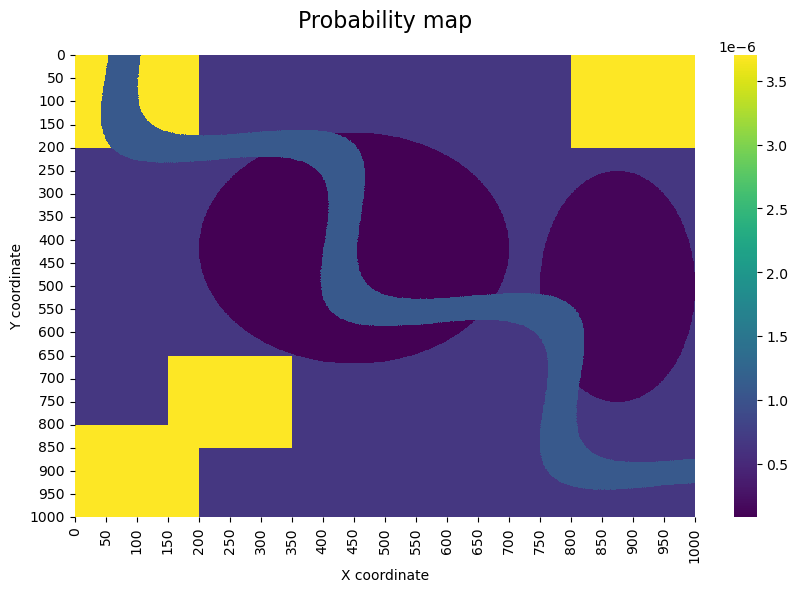

In [20]:
# Generate probability map from geographical map
PROB_GEO_MAP = geographicalFeatureProbability(GEO_MAP)

# Plot probability map as heatmap
plt.figure(figsize=(10, 6))
plt.tight_layout()
ax = sns.heatmap(PROB_GEO_MAP, cmap='viridis')
ticks = np.arange(0, GEO_MAP.shape[0]+50, 50)

# Set title + labels
ax.set_title('Probability map', pad=20).set_fontsize('16')
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')

# Set ticks
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)

# Show figure
plt.show()

##### A.3 - The `geographicalSample` function

This function samples $n$ individuals based on a probability distribution generated by the function `geographicalFeatureMap`. It returns an array of coordinate pairs $(x,y)$, where $x$ and $y$ represent the map coordinates of each sampled individual. The sampling is weighted according to geographical features, computed with the function `geographicalFeatureProbability`, meaning that the probability of a random individual being located in coordinates $(x,y)$ is proportional to the geographical feature $f$ in which the coordinate is located.

Pseudocode:

```
function geographicalSample(n_individuals):
    # Generate probability map for geographical map of size NxN (N = map size)
    probability_map <- geographicalFeatureProbability()

    # Create empty array to store sampled individuals
    individuals <- empty array of size n_individuals

    # Random sampling of N individuals from the map
    for i from 1 to n_individuals:
        # Sample a cell from the probability map using weighted random selection
        index <- choose a random index from 1 to N^2 with probability proportional to probability_map[index]
        
        # Calculate 2D coordinates from the index
        x <- index mod N # Modulo
        y <- int(index / N) # Integer division

        # Save sampled individual coordinates
        individuals[i] <- (x, y)
    end for

    return individuals
end function
```

In [21]:
def geographicalSample(geographical_feature_probability: np.ndarray, n_individuals: int = 1000, map_settings: util.GeographicalMapSettings = DEFAULT_GEO_MAP_SETTINGS) -> np.ndarray:
  '''
  Samples n individuals from the geographical map.

  Args:
    n (int): Number of individuals to sample
  
  Returns:
    np.ndarray: Array of tuples containing x and y coordinates of sampled individuals
  '''

  # Create empty array to store sampled individuals
  individuals = np.zeros((n_individuals, 2), dtype=int)

  # Flatten probability map to a 1D array
  flat_probability_map = geographical_feature_probability.flatten()

  # Sample n individuals from the probability map
  for i in range(n_individuals):
    # Sample a cell from the probability map (flatten the map to a 1D array and use the probability as weights)
    index = np.random.choice(map_settings.size**2, p=flat_probability_map)
    
    # Convert the index to 2D coordinates
    x, y = np.unravel_index(index, [map_settings.size, map_settings.size])

    # Append tuple of coordinates to individuals array
    individuals[i] = (x, y)

  return individuals

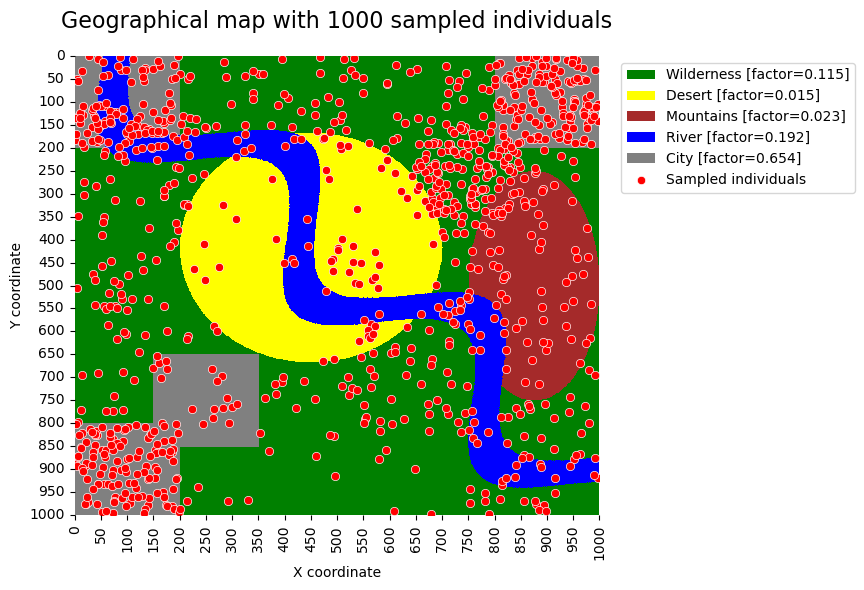

In [22]:
# Plotting geographical map + 1000 random sampled individuals

# Create subplot for geographical map + sampled individuals
_, ax = plt.subplots(figsize=(10, 6))

# Plot geographical map using default map settings and extract generated legend
plotGeographicalMap(GEO_MAP, ax=ax, show_legend=True)
geomap_legend = ax.get_legend()

# Sample individuals from geographical map
n_individuals = 1000
SAMPLED_GEO_INDIVIDUALS = geographicalSample(PROB_GEO_MAP, n_individuals)

# Plot sampled individuals
ax = sns.scatterplot(x=SAMPLED_GEO_INDIVIDUALS[:, 0], y=SAMPLED_GEO_INDIVIDUALS[:, 1], ax=ax, color='red', label='Sampled individuals')
ax.set_title(f'Geographical map with {n_individuals} sampled individuals', pad=20).set_fontsize('16')
ax.legend(handles=geomap_legend.legend_handles + ax.get_legend().legend_handles, loc='upper right', bbox_to_anchor=(1.5, 1.00))

# Show figure
plt.show()

##### A.4 - Compute the Euclidean distance between all pairs of individuals in the map

To compute the euclidean distance between all pairs of individuals in the map, the function `euclDistMatrix` defined in point A.2 of Scenario 1 will be used.

Pseudocode:

```
individuals = geographicalSample(desired number of individuals)
distMatrix = euclDistMatrix(individuals)
```

In [23]:
# Compute distance matrix between sampled individuals
DIST_GEO_INDIVIDUALS = euclDistMatrix(SAMPLED_GEO_INDIVIDUALS)

##### A.5 - The `adjMatrixFromDist` function

This function generates an adjacency matrix given a distance matrix and a threshold $\beta$. The function returns the sampled network of friendships between individuals as a $N \times N$ adjacency matrix, where $N$ is the number of individuals in the map. To perform this task, the function must perform the following steps for each pair of individuals $(A,B)$:

1. Sample a random value $u$ from a uniform distribution in the range $[0,1]$.
2. Compute the probability $P(A - B) = P(A \text{ and } B \text{ are friends})$ (see equation 3 in project description).
3. Consider A and B as friends if $u < P(A - B)$.

Pseudocode:

```
function adjMatrixFromDist(dist_matrix, beta):
    adjacency_matrix <- N x N matrix of zeros (where N = dist_matrix size)

    # Iterate over each pair of individuals (A, B)
    for each pair of individuals (A, B) in {1,2,...,N}:
        # Sample a random value u from a uniform distribution [0,1]
        u <- uniform(0, 1)

        # Compute the probability P(A - B) using Equation 3
        P_A_B <- exp(-beta * dist_matrix[A, B])

        # Add edge between A and B if u < P(A - B)
        if (u < P_A_B):
            adjacency_matrix[A, B] <- 1
            adjacency_matrix[B, A] <- 1  # Since the graph is undirected
        end if
    end for

    # Return the adjacency matrix representing the network of friendships
    return adjacency_matrix
end function

```

In [24]:
def adjMatrixFromDist(dist_matrix: np.ndarray, beta: np.double) -> np.ndarray:
  '''
  Creates an friendship network adjacency matrix from a distance matrix.

  Args:
    dist_matrix (np.ndarray): Distance matrix
    beta (np.double): Beta parameter, controls the probability of edge creation
  
  Returns:
    np.ndarray: Adjacency matrix
  '''
  
  # Create empty adjacency matrix
  adj_matrix = np.zeros(dist_matrix.shape)

  # Loop over all individuals
  for i in range(dist_matrix.shape[0]):
    for j in range(i + 1, dist_matrix.shape[1]):
      # Compute probability of edge creation
      prob = np.exp(-beta * dist_matrix[i, j])

      # Sample edge creation
      if np.random.uniform(0, 1) < prob:
        adj_matrix[i, j] = 1
        adj_matrix[j, i] = 1

  # Return adjacency matrix
  return adj_matrix

In [25]:
def plotGeographicalFriendshipNetwork(
    individuals: np.ndarray,
    adj_matrix: np.ndarray,
    ax: Axes | None = None,
):
  if ax is None:
    ax = plt.gca()

  # Create a list to hold the line segments
  line_segments = []

  # Loop over all individuals
  for i in range(len(individuals)):
    for j in range(i + 1, len(individuals)):
      if adj_matrix[i, j] == 1: # If individuals i and j are friends, plot a line between them
        # Save line segment start position and end position
        line_segments.append([individuals[i], individuals[j]])

  # Create a LineCollection from the list of line segments
  lc = LineCollection(line_segments, colors='k', linewidths=0.5)

  # Draw the line collection using seaborn
  ax.add_collection(lc)

  # Plot sampled individuals
  fig = sns.scatterplot(x=individuals[:, 0], y=individuals[:, 1], ax=ax, color='red', label='Sampled individuals')
  
  # Set plot title
  return fig  

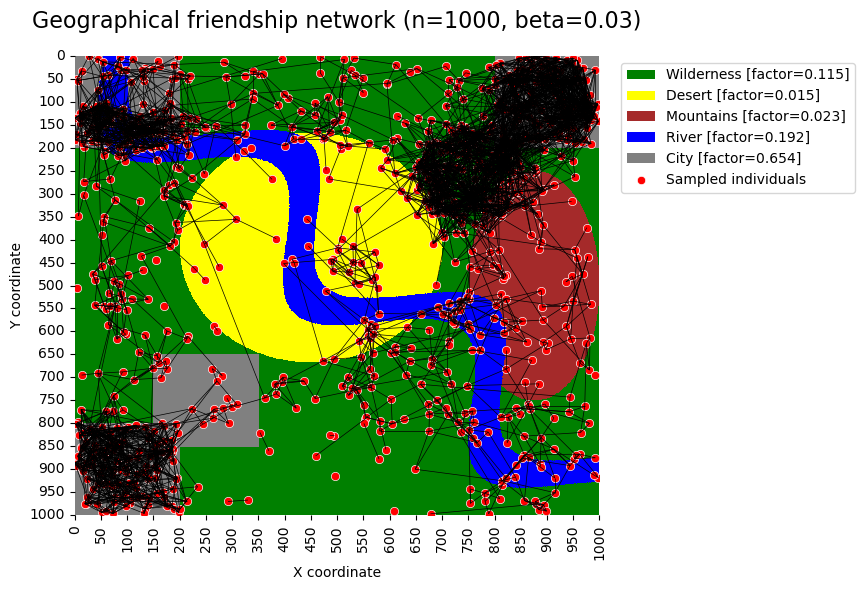

In [26]:
# Generate friendship network adjacency matrix
beta = np.double(0.03)
ADJ_MATRIX = adjMatrixFromDist(DIST_GEO_INDIVIDUALS, beta)

# Create subplot for geographical map + friendship network
_, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot geographical map 
plotGeographicalMap(GEO_MAP, ax=ax, show_legend=True)
geomap_legend = ax.get_legend() # Extract generated legend

# Plot friendship network
ax = plotGeographicalFriendshipNetwork(SAMPLED_GEO_INDIVIDUALS, ADJ_MATRIX, ax=ax)

# Set title + build legend
plt.title(f'Geographical friendship network (n={n_individuals}, beta={beta})', pad=20).set_fontsize('16')
plt.legend(handles=geomap_legend.legend_handles + ax.get_legend().legend_handles, loc='upper right', bbox_to_anchor=(1.5, 1.00))

# Show plot
plt.show()

##### A.6 - The `degreeFromAdjMatrix` function

This function computes the mean degree of a friendship network generated with the function `adjMatrixFromDist`. The function returns the mean degree of the network.

Pseudocode:

```
function degreeFromAdjMatrix(adjacency_matrix):
    # Compute the degree of each node
    degrees = [0, 0, ..., 0] # Array of N zeros (where N = adjacency_matrix height)
    for i in {1,2,...,N}:
        for j in {1,2,...,N}:
            tot_degree[i] += adjacency_matrix[i,j]
        end for
    end for

    # Compute the mean degree of the network
    mean_degree <- mean(degrees)

    # Return the mean degree
    return mean_degree
end function
```
```

In [27]:
def degreeFromAdjMatrix(adj_matrix: np.ndarray) -> float:
  '''
  Computes the degree of each node in the graph.

  Args:
    adj_matrix (np.ndarray): Adjacency matrix

  Returns:
    np.ndarray: Array of degrees for each node in the graph
  '''
  
  # Create empty array to store degrees
  degrees = np.sum(adj_matrix, axis=0)

  # Return mean degree
  return np.mean(degrees)

#### B - Design the pseudocode for the Geographical-based Random Inhabitant Map

##### B.1 - Study of distances in the geographical-based random map for $n = 1000$

In [28]:
# Generate map
n_individuals = 1000
individuals = geographicalSample(PROB_GEO_MAP, n_individuals) # Sample individuals from geographical map
dist_matrix = euclDistMatrix(individuals) # Compute Euclidean distance among individuals
adj_matrix = adjMatrixFromDist(dist_matrix, np.double(.03)) # Generate a friendship network from the generated map

**Minimum, maximum and mean Euclidean distance between all pairs of individuals**

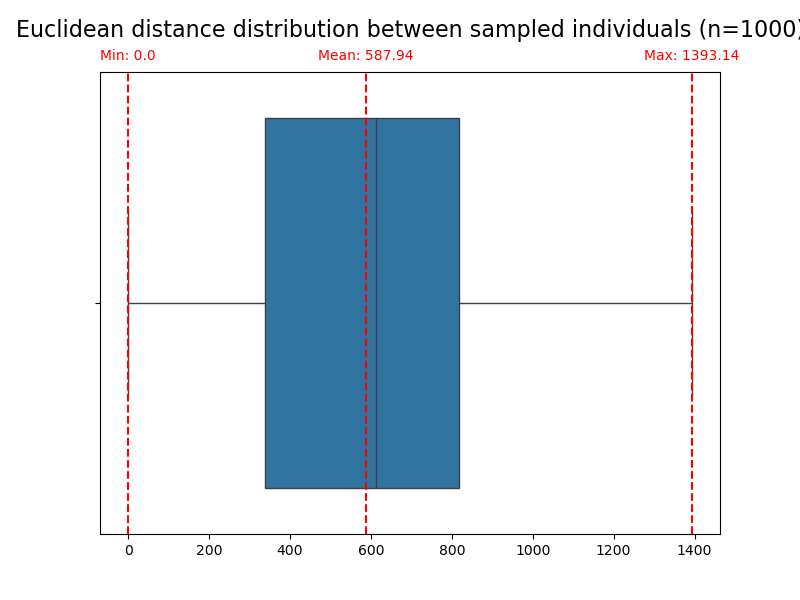

In [64]:
# Generate general statistics on the distance matrix
cropped_dist_matrix = dist_matrix[np.triu_indices(n_individuals, k=1)] # Extract upper triangular matrix without diagonal
min_distance = np.min(cropped_dist_matrix) # Minimum distance
max_distance = np.max(cropped_dist_matrix) # Maximum distance
mean_distance = np.mean(cropped_dist_matrix) # Mean distance

# boxplot of cropped_dist_matrix
plt.figure(figsize=(8, 6))
sns.boxplot(cropped_dist_matrix, orient='h')

# Average x axis position of the boxplot
rounded_mean_distance = round(mean_distance)

# Add vertical lines for min, max and mean distances
plt.axvline(min_distance, color='red', linestyle='--', label='Min Distance')
plt.axvline(max_distance, color='red', linestyle='--', label='Max Distance')
plt.axvline(rounded_mean_distance, color='red', linestyle='--', label='Mean Distance')

# Add annotations with offsets for clarity
y_position = plt.ylim()[1] * 1.1  # Adjust this as necessary
plt.text(min_distance, y_position, f'Min: {np.round(min_distance, 2)}', color='red', ha='center', va='top')
plt.text(max_distance, y_position, f'Max: {np.round(max_distance, 2)}', color='red', ha='center', va='top')
plt.text(rounded_mean_distance, y_position, f'Mean: {np.round(mean_distance, 2)}', color='red', ha='center', va='top')

# Add title
plt.title(f'Euclidean distance distribution between sampled individuals (n={n_individuals})', pad=25).set_fontsize('16')

# Show the plot
plt.show()

**Sampled individuals distribution among geographical features**

In [30]:
# List of distances per geographical feature
n_individuals_per_feature = np.zeros(len(DEFAULT_GEO_MAP_SETTINGS.features))
individuals_per_feature = [[] for _ in range(len(DEFAULT_GEO_MAP_SETTINGS.features))]

# For each individual, extract its geographical feature and append its distance to the list of distances for that feature
for i in range(n_individuals):
  # Unpack individual coordinates
  x, y = individuals[i]

  # Get geographical feature at the given coordinates
  current_feature = getCoordinateFeature(GEO_MAP, x, y)

  # Append individual index to the list of individuals for the current geographical feature
  individuals_per_feature[int(current_feature.type.value)].append(individuals[i])

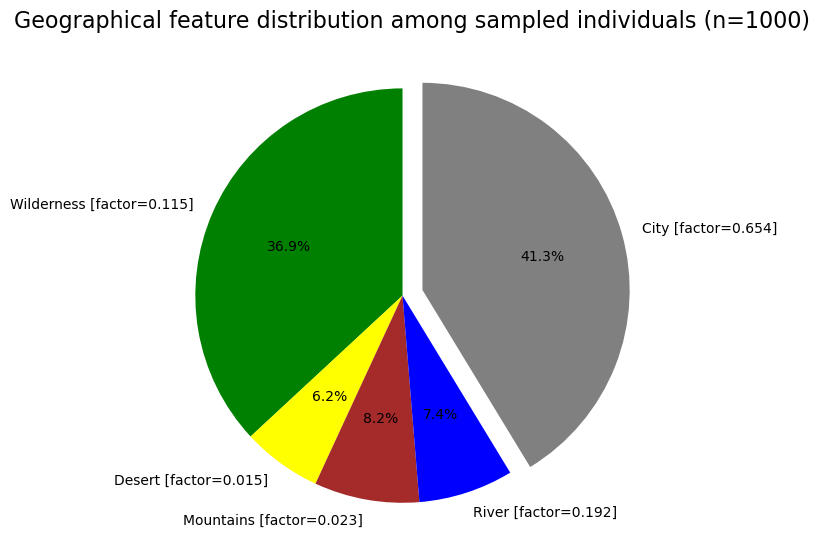

In [31]:
# Count individuals per feature
n_individuals_per_feature = [len(individuals) for individuals in individuals_per_feature]

# Explode the feature with the highest number of individuals
explode = np.zeros(len(DEFAULT_GEO_MAP_SETTINGS.features))
explode[np.argmax(n_individuals_per_feature)] = 0.1

# Define image size
plt.figure(figsize=(10, 6))

# Plot piechart
plt.pie(n_individuals_per_feature,
  labels=[f"{feature.name} [factor={round(feature.ease_of_living, 3)}]" for feature in DEFAULT_GEO_MAP_SETTINGS.features],
  colors = [feature.color for feature in DEFAULT_GEO_MAP_SETTINGS.features],
  autopct='%1.1f%%',
  startangle=90,
  explode=explode,
)

# Fix aspect ratio to be equal so that pie is drawn as a circle
plt.axis('equal')

# Add title
plt.title(f'Geographical feature distribution among sampled individuals (n={n_individuals})', pad=25).set_fontsize('16')

From this plot is possible to notice an important characteristic of the geographical-based random map: even if the city area has a higher *ease of living* factor $s_f$, the number of individuals living in the city is around the same as the number of individuals living in the wilderness. This behavior is expected, as the *ease of living* factor influences the likelihood of individuals being located in certain areas, but it's also balanced against the relative size of those areas.

Indeed, the city area, with a value $s_{city}=0.192$, is the smallest region on the map. Conversely, the wilderness, which encompasses the largest area, has a value $s_{wilderness}=0.115$ — approximately 40% larger. Despite this, both the city and wilderness areas have similar population counts.

**Minimum, maximum and mean Euclidean distance between individuals per geographical feature**

Mean distance for Wilderness = 503.68
Mean distance for Desert = 221.73
Mean distance for Mountains = 181.46
Mean distance for River = 501.3
Mean distance for City = 653.5


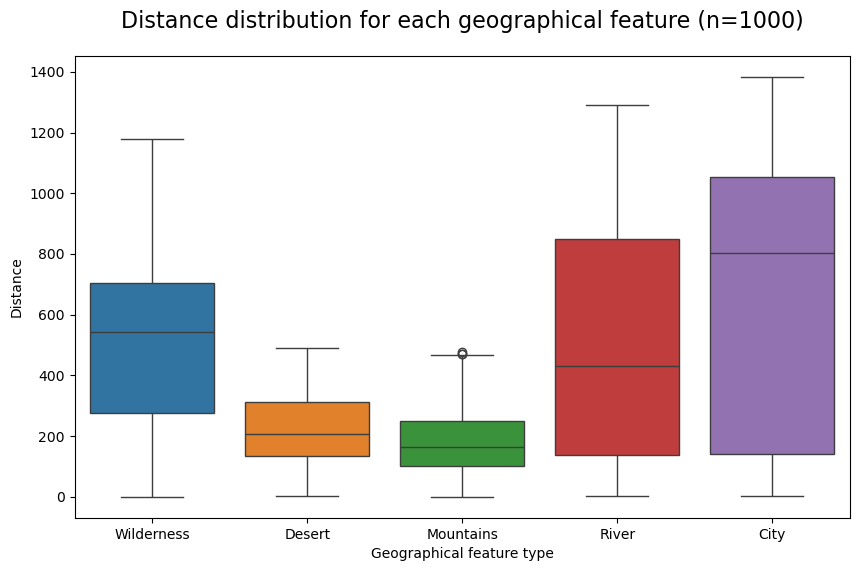

In [32]:
# For each geographical feature, compute the distance matrix and extract the upper triangular matrix without diagonal
distances_per_feature = [euclDistMatrix(np.array(individuals))[np.triu_indices(len(individuals), k=1)] for individuals in individuals_per_feature]

# Print mean distance for each geographical feature
for i, feature in enumerate(DEFAULT_GEO_MAP_SETTINGS.features):
  print(f"Mean distance for {feature.name} = {np.round(np.mean(distances_per_feature[i]), 2)}")

# Plot boxplots for each geographical feature
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.boxplot(data=distances_per_feature, ax=ax)
ax.set_title(f'Distance distribution for each geographical feature (n={n_individuals})', pad=20).set_fontsize('16')
ax.set_xlabel('Geographical feature type')
ax.set_ylabel('Distance')
ax.set_xticks(range(len(DEFAULT_GEO_MAP_SETTINGS.features)))
ax.set_xticklabels([feature.name for feature in DEFAULT_GEO_MAP_SETTINGS.features])
 
# Show the plot
plt.show()

The average distance between individuals within the same type of terrain also depends on both the size and location of these features. This effect is clear in the provided plot, which shows that the average distance between individuals in the desert and mountains — regions with lower $s_f$ values — is greater than that between individuals in the city and along the river, which have the highest $s_f$ values. 

Such behavior is expected since the three cities are placed in different areas on the map (two in the bottom-left and one in the top-right), in contrast to the river, which extends across the map following a sinusoidal path. Individuals in these geographical feature are less centralized than other areas of the map, and they are likely to exhibit a higher mean distance. This assumption is also confirmed by the upper bound of the boxplot, which shows that the maximum distance between individuals in the city and along the river is greater than the maximum distance between individuals of the other geographical features.

The main difference from the previous map generation approach, where the geographical areas were not taken into account, is that the distances between individuals are not uniformly distributed across the map. In fact, the following plot shows the distribution of the Euclidean distances between all pairs of individuals in the map:

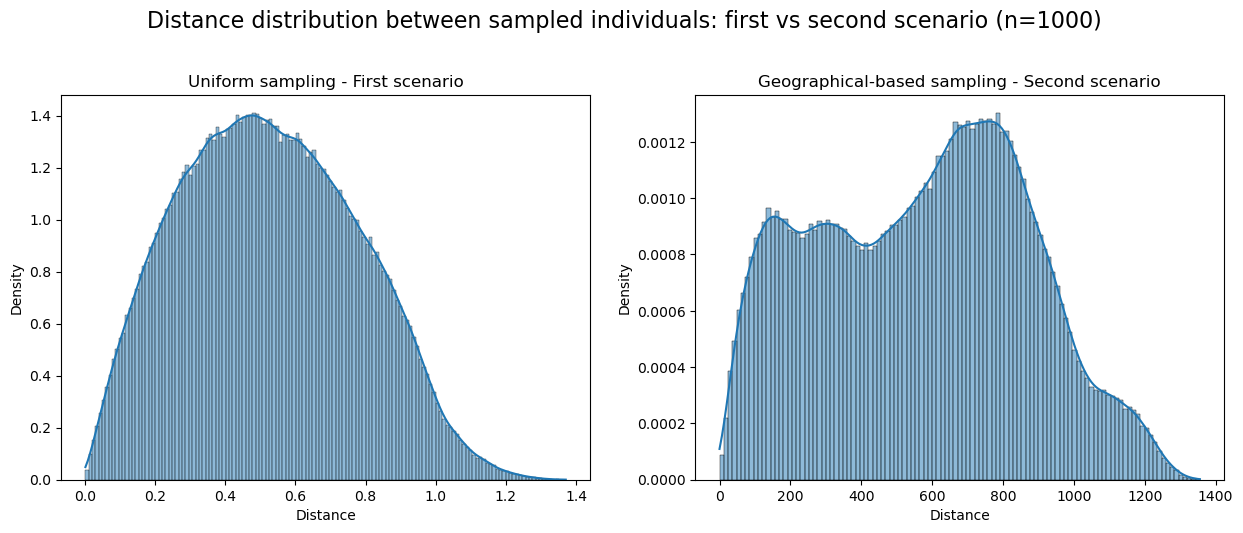

In [33]:
# Extract upper triangular matrix without diagonal
#   (distances between individuals are symmetric and on the diagonal we have only zeros)
unique_distances = DIST_GEO_INDIVIDUALS[np.triu_indices(n_individuals, k=1)]

# Sample individuals from normal map
unique_uniform_individuals_distances = euclDistMatrix(sample_uniform_random_individuals())[np.triu_indices(n_individuals, k=1)]

# Two plots side by side
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Set title for both plots
fig.suptitle(f'Distance distribution between sampled individuals: first vs second scenario (n={n_individuals})', y=1.05, fontsize=16)

# Plot the distribution of the distances between individuals sampled from a uniform distribution
sns.histplot(unique_uniform_individuals_distances, kde=True, stat='density', ax=ax[0])
ax[0].set_xlabel('Distance')
ax[0].set_ylabel('Density')
ax[0].set_title('Uniform sampling - First scenario')

# Plot the distribution of the distances between individuals
sns.histplot(unique_distances, kde=True, stat='density', ax=ax[1])
ax[1].set_xlabel('Distance')
ax[1].set_ylabel('Density')
ax[1].set_title('Geographical-based sampling - Second scenario')

# Show the plot
plt.show()

##### B.2 - Exploring $\beta$ in the geographical-based random map for $n = 1000$

In [34]:
betas = [0.001, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 0.7, 1.0]

adj_matrices = []

# Generate new individuals
n_individuals = 1000
individuals = geographicalSample(PROB_GEO_MAP, n_individuals)
 
# Compute distance matrix between sampled individuals
dist_matrix = euclDistMatrix(individuals)

# Generate maps for each beta
for beta in betas:
  print("Generating map for beta = {}".format(beta))

  # Save start time
  start = time.time()

  # Generate a friendship network from the generated map
  adj_matrices.append(adjMatrixFromDist(dist_matrix, np.double(beta)))
  
  # Print time taken to generate map
  print("\t-took {} seconds".format(np.round(time.time() - start, 2)))


Generating map for beta = 0.001
	-took 0.81 seconds
Generating map for beta = 0.01
	-took 0.77 seconds
Generating map for beta = 0.03
	-took 0.76 seconds
Generating map for beta = 0.05
	-took 0.76 seconds
Generating map for beta = 0.1
	-took 0.76 seconds
Generating map for beta = 0.3
	-took 0.76 seconds
Generating map for beta = 0.5
	-took 0.77 seconds
Generating map for beta = 0.7
	-took 0.77 seconds
Generating map for beta = 1.0
	-took 0.79 seconds


**$\beta$ and the mean degree of the friendship network**

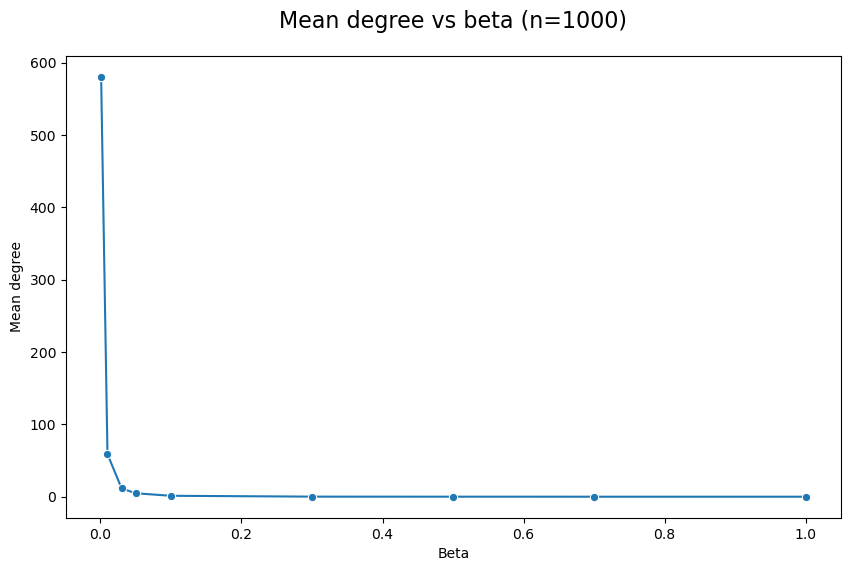

In [35]:
# Plot mean degrees
plt.figure(figsize=(10, 6))
sns.lineplot(x=betas, y=[degreeFromAdjMatrix(adj_matrix) for adj_matrix in adj_matrices], marker='o')

# Add title
plt.title(f'Mean degree vs beta (n={n_individuals})', pad=20).set_fontsize('16')

# Axis labels
plt.xlabel('Beta')
plt.ylabel('Mean degree')

# Show the plot
plt.show()

As it is possible to see from the plot above, the mean degree have reasonable values only in a really small range of $\beta$ values, approximately between 0.1 and 0.3. Outside this range, the mean degree is either extremely high (tends to the maximum degree of the graph) or extremely low (tends to zero).

To provide more significant results, the following plots will be based on beta values that produces the following mean degree values: 5, 10, 15, 30, 50, 100. To estimate the right $\beta$ values, will be used a simple branching algorithm that starts from a window of $\beta$ values and iteratively reduces the window size until the mean degree is approximately equal to the desired value (the threshold is set to 0.05).

In [36]:
# Branch and bound method to find the optimal beta to get mean degree = 10
def branchAndBoundMeanDegree(dist_matrix: np.ndarray, target_mean_degree: int, threshold: float = 3, verbose = False) -> np.double:
  '''
  Finds the optimal beta value to get a target mean degree using the branch and bound method.

  Args:
    dist_matrix (np.ndarray): Distance matrix
    target_mean_degree (int): Target mean degree
    threshold (float): Threshold to stop the search
    verbose (bool): Whether to print the current state of the search

  Returns:
    np.double: Optimal beta value
  '''

  # Generate initial beta value
  min_beta = np.double(0.001)
  max_beta = np.double(0.5)

  # Compute initial mean degree
  mean_degree = degreeFromAdjMatrix(adjMatrixFromDist(dist_matrix, min_beta))

  # Loop until we find the optimal beta
  beta = np.double(0)
  while abs(mean_degree - target_mean_degree) > threshold:
    # Compute new beta value
    beta = (min_beta + max_beta) / 2

    # Print current window and beta value
    if verbose: print("Current window: [{}, {}], current beta: {}".format(min_beta, max_beta, beta))

    # Compute new mean degree
    mean_degree = degreeFromAdjMatrix(adjMatrixFromDist(dist_matrix, beta))

    # Update min or max beta value
    if mean_degree < target_mean_degree:
      if verbose: print("\tMean degree = {} < {} = target mean degree".format(mean_degree, target_mean_degree))
      # Move window to the left
      max_beta -= (max_beta - min_beta) / 2
    else:
      if verbose: print("\tMean degree = {} > {} = target mean degree".format(mean_degree, target_mean_degree))
      # Move window to the right
      min_beta += (max_beta - min_beta) / 2

  # Return optimal beta value
  return beta

# Find optimal beta values to get the desired mean degrees
desired_mean_degrees = [5, 10, 15, 30, 50, 100]
optimal_betas = [branchAndBoundMeanDegree(DIST_GEO_INDIVIDUALS, degree, threshold=.05) for degree in desired_mean_degrees]

# Print optimal beta values
print("Optimal beta values to find mean degree = {}".format(desired_mean_degrees))
for beta, mean_degree in zip(optimal_betas, desired_mean_degrees):
  print("\t- Beta = {} for mean degree = {}".format(beta, mean_degree))

Optimal beta values to find mean degree = [5, 10, 15, 30, 50, 100]
	- Beta = 0.04778125 for mean degree = 5
	- Beta = 0.032796630859375 for mean degree = 10
	- Beta = 0.0258525390625 for mean degree = 15
	- Beta = 0.016602315902709962 for mean degree = 30
	- Beta = 0.011606966972351074 for mean degree = 50
	- Beta = 0.006872504896484315 for mean degree = 100


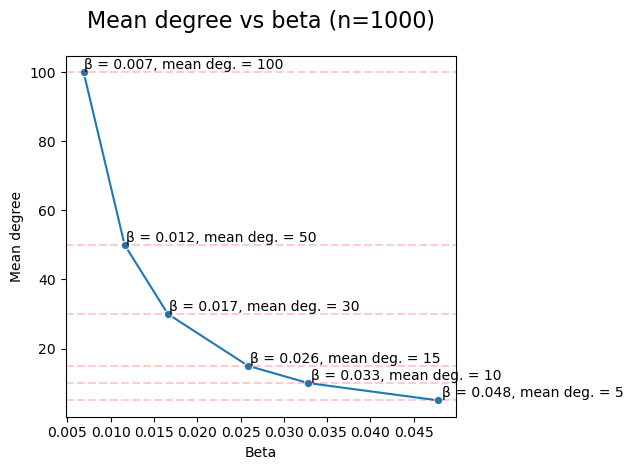

In [37]:
# Lineplot of mean degree vs beta zoomed in on the optimal beta values
plt.figure()
sns.lineplot(x=optimal_betas, y=desired_mean_degrees, marker='o')

# Add title
plt.title(f'Mean degree vs beta (n={n_individuals})', pad=20).set_fontsize('16')

# Axis labels
plt.xlabel('Beta')
plt.ylabel('Mean degree')

# Add y lines for the desired mean degrees + show actual mean degree values
for i, beta in enumerate(optimal_betas):
  plt.axhline(desired_mean_degrees[i], color='red', linestyle='--', label='Mean degree = {}'.format(desired_mean_degrees[i]), alpha=0.2)
  plt.text(float(beta) * 1.01, desired_mean_degrees[i], f'β = {np.round(beta, 3)}, mean deg. = {desired_mean_degrees[i]}', ha='left', va='bottom')

# Tight layout (no overlapping)
plt.tight_layout()

# Show the plot
plt.show()

In the following plot, is possible to see six different geographical-based random maps, each one with a different $\beta$ value found with the branching algorithm.

In [38]:
# For each optimal beta value, generate a friendship network to later analyze its properties
optimal_adj_matrices = [adjMatrixFromDist(DIST_GEO_INDIVIDUALS, beta) for beta in optimal_betas]

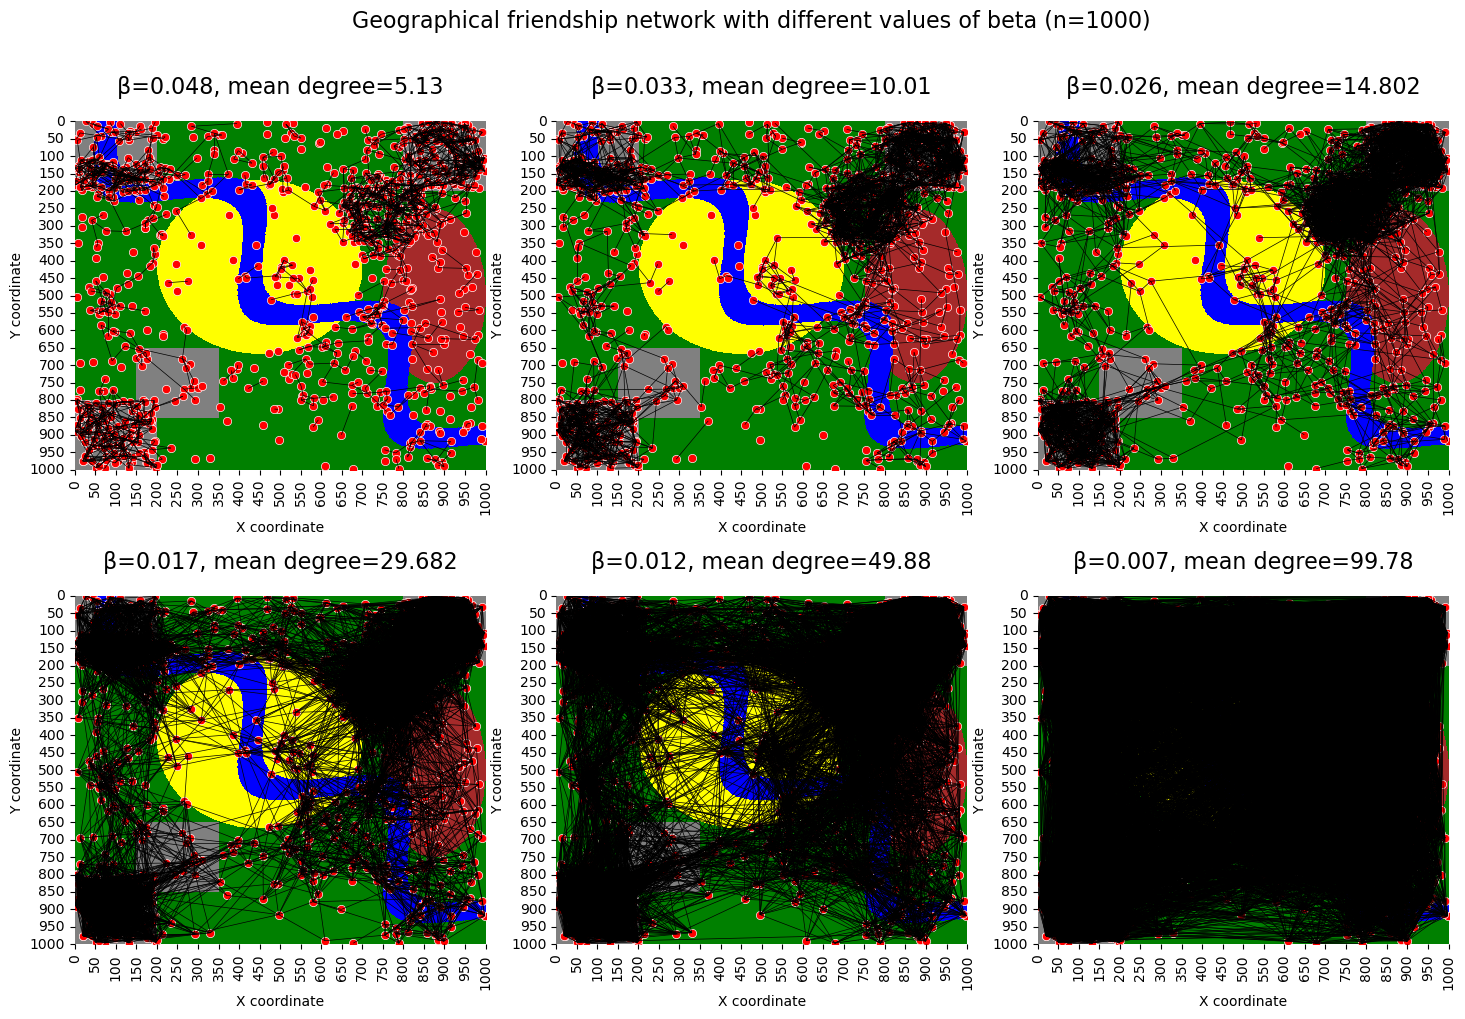

In [39]:
# Create subplots for geographical map + friendship network
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Set subplot title
fig.suptitle(f'Geographical friendship network with different values of beta (n=1000)', y=1, fontsize=16)

# Add space between each axis
fig.tight_layout(pad=3.0, w_pad=2.0, h_pad=7.0)

# Loop over all desired mean degrees
for i, beta in enumerate(optimal_betas):
  # Get current subplot
  ax = axes[i//3, i%3]

  # Compute mean degree
  mean_degree = degreeFromAdjMatrix(optimal_adj_matrices[i])

  # Plot geographical map 
  plotGeographicalMap(GEO_MAP, ax=ax, show_legend=False)

  # Plot friendship network
  plotGeographicalFriendshipNetwork(SAMPLED_GEO_INDIVIDUALS, optimal_adj_matrices[i], ax=ax)

  # Disable legend for geographical map
  ax.get_legend().remove()

  # Set title
  ax.set_title(f'β={np.round(beta, 3)}, mean degree={np.round(mean_degree, 3)}', pad=20).set_fontsize('16')

# Plot figure
plt.show()

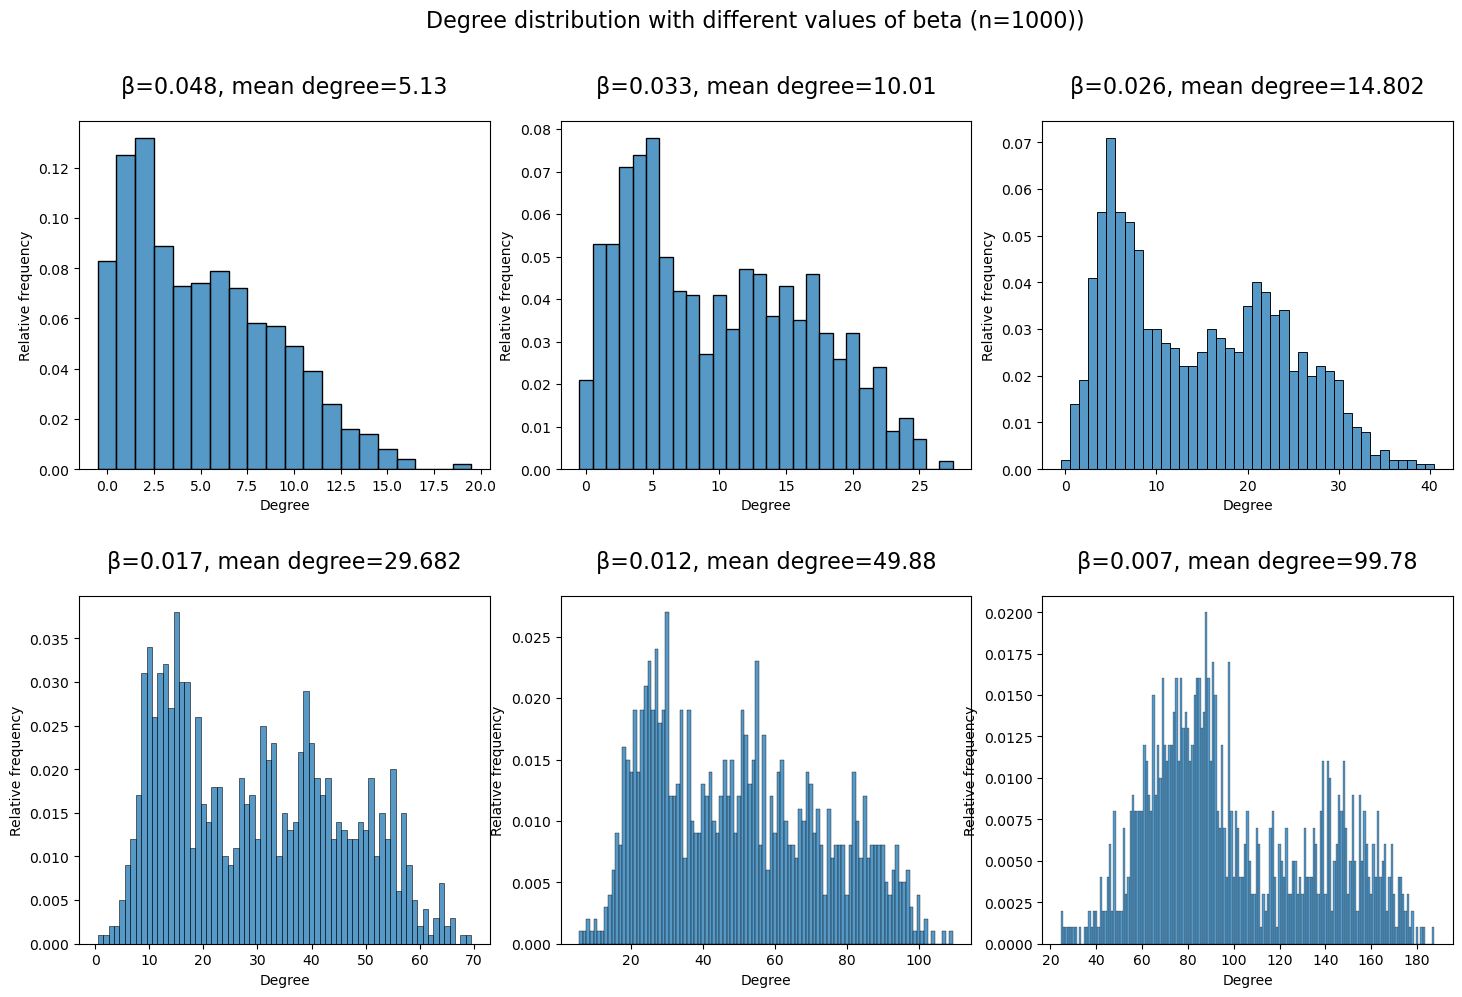

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Set subplot title
fig.suptitle(f'Degree distribution with different values of beta (n={n_individuals}))', y=1, fontsize=16)

# Add space between each axis
fig.tight_layout(pad=3.0, w_pad=2.0, h_pad=7.0)

# Loop over all desired mean degrees
for i, beta in enumerate(optimal_betas):
  # Get current subplot
  ax = axes[i//3, i%3]

  # Compute degree distribution
  degrees = np.array(optimal_adj_matrices[i].sum(axis=0))

  # Plot degree distribution as histogram
  sns.histplot(degrees, ax=ax, stat='probability', discrete=True)

  # Set axis labels
  ax.set_xlabel('Degree')
  ax.set_ylabel('Relative frequency')

  # Set title
  ax.set_title(f'β={np.round(beta, 3)}, mean degree={np.round(degrees.mean(), 3)}', pad=20).set_fontsize('16')

# Plot figure
plt.show()

As expected, from the plot above is possible to see that the degree distribution of the geographical-based random map does not follow a binomial distribution as the previous map generation approach. 

**Adajency matrix sturcture and average path length**

Similarly as done before with the Erdos-Renyi model, in this section will be explored the structure of the adajency matrices of the geographical-based random map, analyzing its structure with different $\beta$ values.

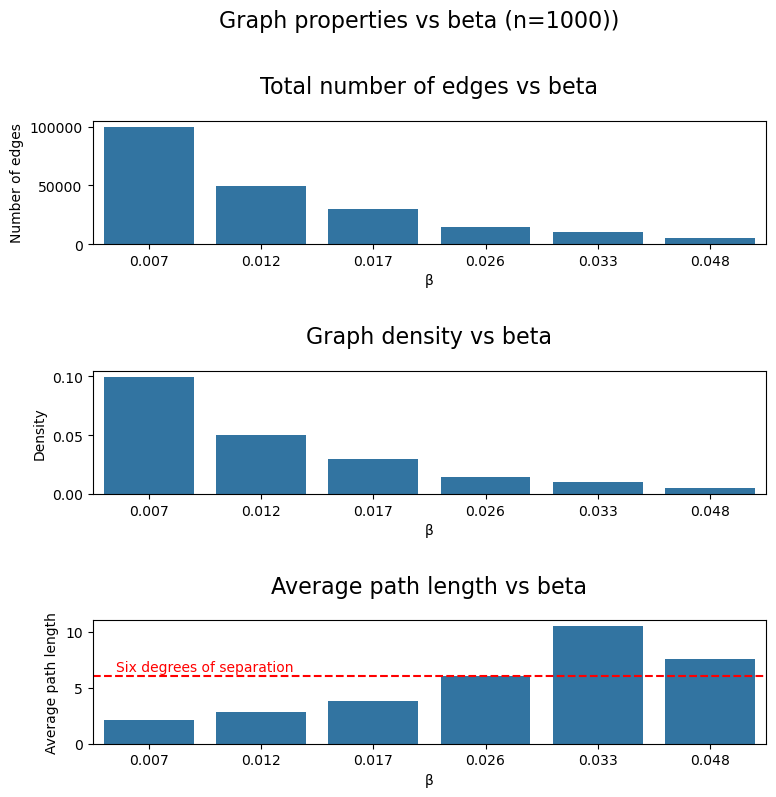

In [41]:
# Convert adjacency matrix to igraph graph
graphs = [ig.Graph.Adjacency(adj_matrix.tolist()) for adj_matrix in optimal_adj_matrices]

# Acquire information about these graphs (density, average path lenght)
average_path_lengths = [graph.average_path_length() for graph in graphs]
densities = [graph.density() for graph in graphs]
tot_edges = [graph.ecount() for graph in graphs]

# Plot total edges, density and average degree
fig, ax = plt.subplots(3, 1, figsize=(8, 8))

# Set subplot title
fig.suptitle(f'Graph properties vs beta (n={n_individuals}))', y=1, fontsize=16)

# Add space between subplots
fig.tight_layout(pad=3, h_pad=7.0)

# Plot total number of edges
sns.barplot(x=np.round(optimal_betas, 3), y=tot_edges, ax=ax[0])
ax[0].set_title('Total number of edges vs beta', pad=20).set_fontsize('16')
ax[0].set_xlabel('β')
ax[0].set_ylabel('Number of edges')

# Plot graph density
sns.barplot(x=np.round(optimal_betas, 3), y=densities, ax=ax[1])
ax[1].set_title('Graph density vs beta', pad=20).set_fontsize('16')
ax[1].set_xlabel('β')
ax[1].set_ylabel('Density')

# Plot the average path length for each graph and show beta values and average path length values as annotations
sns.barplot(x=np.round(optimal_betas, 3), y=average_path_lengths, ax=ax[2])
ax[2].set_title('Average path length vs beta', pad=20).set_fontsize('16')
ax[2].set_xlabel('β')
ax[2].set_ylabel('Average path length')

# Highlight the average path length = 6 line (six-degree of separation)
ax[2].axhline(6, color='red', linestyle='--')
ax[2].text(0.5, 6.2, 'Six degrees of separation', ha='center', va='bottom', color='red')

# Show the plot 
plt.show()

From the three plots above, is possible to gather important characteristics of the implemented geographical-based friendship network model. In particular, is possible to note that with the increase of $\beta$ values, the graph tends to be more disconnected, leading sparser adjacency matrices (low density) and a lower total number of edges.

On the other hand, the average path length tends to increase when $\beta$ increases. As the graph becomes more disconnected, there are fewer paths between two nodes, leading to friendlier individuals being further apart from each other.

From the last plot, is possible to note that the *six degrees of separation* theory does not apply to all values of $\beta$. The reason for this is that with this model individuals are more likely to form friendships with others who are geographically closer to them, resulting in high clustering within the friendship network. Local clusters are highly connected internally but have weak connections to the rest of the network due to the model discouraging long-range connections.

**Connected components and eigendecomposition**

Similarly as done before, with the Erdős–Rényi model, in this section will be explored the relationship between the largest connected component and the eigenvalues of the geographical-based random map, analyzing the data with different $\beta$ values.

To perform this task, will be analyzed the relationship between the number of connected component and the largest connected component with the eigendecomposition of the graph's Laplacian matrix (refer to point *B.2 - Connected components and eigendecomposition* from Scenario 1 for the mathematical rationale behind this analysis).

In [42]:
# Lists to save results
n_connected_components = []
n_second_smallest_eigenvalues = []

for graph, beta in zip(graphs, optimal_betas):
  # Graph's Laplacian matrix eigendecomposition
  eigenvalues, eigenvectors = np.linalg.eig(graph.laplacian())

  # Compute graph components
  components = graph.components()

  # Compute the total number of orthonormal eigenvectors associated with eigenvalue 0
  num_zero_eigenvectors = np.sum(np.isclose(eigenvalues, 0))
  n_connected_components.append(num_zero_eigenvectors)

  # Find largest connected component of graph
  largest_component = components.giant()

  # Find second smallest eigenvalue
  second_smallest_eigenvalue = np.sort(eigenvalues)[1]

  # Find the second smallest eigenvalue (Theorem: Fiedler vector)
  n_second_smallest_eigenvalues.append(second_smallest_eigenvalue)

  # Print analysis results
  print("β = {}".format(beta))
  print("\t- Expected number of connected components = {}".format(num_zero_eigenvectors))
  print("\t- Actual number of connected components = {}".format(len(components)))
  print("\t- Second smallest eigenvalue = {}".format(second_smallest_eigenvalue))
  print("\t- Size of largest connected component = {}".format(largest_component.vcount()))

β = 0.04778125
	- Expected number of connected components = 116
	- Actual number of connected components = 116
	- Second smallest eigenvalue = (-1.7576783062719579e-15-2.710249753580515e-16j)
	- Size of largest connected component = 462
β = 0.032796630859375
	- Expected number of connected components = 26
	- Actual number of connected components = 26
	- Second smallest eigenvalue = -3.5353994857093933e-15
	- Size of largest connected component = 971
β = 0.0258525390625
	- Expected number of connected components = 3
	- Actual number of connected components = 3
	- Second smallest eigenvalue = 0.0
	- Size of largest connected component = 998
β = 0.016602315902709962
	- Expected number of connected components = 1
	- Actual number of connected components = 1
	- Second smallest eigenvalue = 0.1910928606726387
	- Size of largest connected component = 1000
β = 0.011606966972351074
	- Expected number of connected components = 1
	- Actual number of connected components = 1
	- Second smallest eig

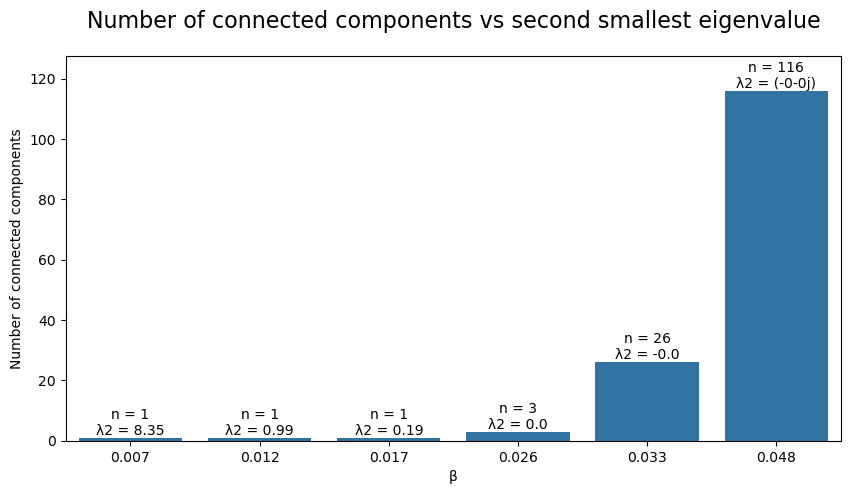

In [43]:
# Plot analysis results
plt.subplots(1, 1, figsize=(10, 5))
fig = sns.barplot(x=np.round(optimal_betas,3), y=n_connected_components)
fig.set_title('Number of connected components vs second smallest eigenvalue', pad=20).set_fontsize('16')
fig.set_xlabel('β')
fig.set_ylabel('Number of connected components')
fig.set_ylim(0, 1.1 * max(n_connected_components)) # Add spacing between bars and plot border on y axis

# Add text showing the number of connected components + second smallest eigenvalue
for i in range(len(optimal_betas)):
  fig.text(len(optimal_betas)-(i+1), n_connected_components[i], 'n = {}\nλ2 = {}'.format(n_connected_components[i], np.round(n_second_smallest_eigenvalues[i], 2)), ha='center', va='bottom')

# Show figure
plt.show()

Even with this new model, the assumptions made in section **B.2** of the first scenario still hold: the number of connected components in a graph equals the number of orthonormal eigenvectors associated with eigenvalue $\lambda = 0$ of the graph Laplacian, and from the second smallest eigenvalue $\lambda_1$ of the Laplacian matrix of the graph, it is possible to estimate the size of the largest connected component of the graph.

To have a clearer picture of the relationship between the number of connected components and the largest connected component, please read the cited section of the first scenario.

#### C - Regarding the `adjMatrixFromDist` function for generating Friendship Networks

##### C.1 - Geographical-based model to model real-world friendship networks

The relationship between geographical features and the grouping of friends in the network showcases how the physical environment can influence the formation of social ties, which is a crucial aspect of real-world friendship networks. The model takes into account the geographical distance between individuals, which is a key factor in the formation of friendships in real life as two individuals are more likely to be friends if they live close to each other. 

For certain values of $\beta$, the geographical-based model exhibits the *six degrees of separation* theory, an important characteristic of the small-world phenomenon (learn more [here](https://en.wikipedia.org/wiki/Small-world_network)).

In conclusion, for the listed reasons the geographical-based model offers a more realistic approach to modeling real-world friendship networks than the Erdős–Rényi model developed and analyzed in the first scenario.

##### C.2 - Limitations of the geographical-based model

While this model enhances realism by taking in consideration the proximity between individuals, this model does not describe the complexity of real-world friendship networks. In particular, the model does not take into account the social characteristics of the individuals but only the geographical distance between the two, for example:

- Shared interests between two individuals
- Religion
- Social status
- Age
- Gender (in some cultures)
- Etc.

In addition, with the modern society where the use of Internet and digital devices is widespread, the geographical distance between two individuals is not a crucial factor in the formation of a friendship. For instance, via social media or other forms of communication it is possible to form friendships with people who live on the other side of the world.

#### D - Real-time simulation of the two friendship network models

The video will showcase the two friendship network models in real-time. The video will be created using the `matplotlib.animation` module, which provides an easy way to create animations from plots.

##### D.1 - Erdős–Rényi model animation

##### D.2 - Geographic-based model animation

In [168]:
def plotAnimatedGeographicalFriendshipNetwork(n_individuals, beta, n, refresh_rate=500, edges_per_frame = 100, individuals_per_frame = 50):  
  # Function to generate a map
  def generateMapSimple(n_individuals: int, beta: np.double, map_size: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    # Create new map settings with updated size
    new_map_settings = util.GeographicalMapSettings(DEFAULT_GEO_MAP_SETTINGS.features, size=map_size)

    ## Step 1: generate geographical map
    GEO_MAP = geographicalFeatureMap(map_size)
    ## Step 2: generate probability map from geographical map
    PROB_GEO_MAP = geographicalFeatureProbability(GEO_MAP, new_map_settings)
    ## Step 3: sample individuals from probability map
    SAMPLED_GEO_INDIVIDUALS = geographicalSample(PROB_GEO_MAP, n_individuals, new_map_settings)
    ## Step 4: compute distance matrix between sampled individuals
    DIST_GEO_INDIVIDUALS = euclDistMatrix(SAMPLED_GEO_INDIVIDUALS)
    ## Step 5: generate friendship network from distance matrix
    ADJ_MATRIX = adjMatrixFromDist(DIST_GEO_INDIVIDUALS, beta)

    # Return generated map
    return GEO_MAP, SAMPLED_GEO_INDIVIDUALS, ADJ_MATRIX

  # Generate map with passed parameters
  anim_geo_map, anim_sampled_geo_individuals, anim_adj_matrix = generateMapSimple(
    n_individuals,
    beta,
    n
  )
  
  def setup_plot():
      # Close all
      plt.close('all')
      
      # Create figure and axis
      fig, ax = plt.subplots(figsize=(10, 7))
      plotGeographicalMap(anim_geo_map, ax=ax, show_legend=True)  # Draw the geographical map

      # Add additional entry to the legend for the sampled individuals (using legend_handles)
      legend_elements = [Line2D([0], [0], marker='o', color='red', label='Sampled individuals', markersize=5, linestyle='None')]
      ax.legend(handles=ax.get_legend().legend_handles + legend_elements, loc='upper right', bbox_to_anchor=(1.5, 1.00))
      
      # Add text for elapsed time
      elapsed_time_text = ax.text(1.05, 0.1, '', transform=ax.transAxes)
      # Add progress text for individuals
      progress_text_individuals = ax.text(1.05, 0.05, '', transform=ax.transAxes)
      # Add progress text for edges
      progress_text_edges = ax.text(1.05, 0.0, '', transform=ax.transAxes)

      # Show map characteristics in title
      ax.set_title(f'n={n_individuals}, β={np.round(beta,3)}, mean degree={round(degreeFromAdjMatrix(anim_adj_matrix), 3)}', pad=20).set_fontsize('16')
      
      return fig, ax, (elapsed_time_text, progress_text_individuals, progress_text_edges)

  # Function to update the animation
  pre_time=time.time()
  def update(frame_number, individuals, adj_matrix, ax, total_individuals, total_edges, progress_texts):
      # Print frame number and elapsed time
      elapsed_time = time.time() - pre_time
      progress_texts[0].set_text(f'Frame: {frame_number} (elapsed time: {round(elapsed_time, 2)}s)')

      # Plot 50 individuals at a time
      if frame_number < total_individuals // individuals_per_frame:
          start_idx = frame_number * individuals_per_frame
          end_idx = min((frame_number + 1) * individuals_per_frame, total_individuals)
          ax.scatter(individuals[start_idx:end_idx, 0], individuals[start_idx:end_idx, 1], c='red')

          # Add text showing the number of individuals drawn
          progress_texts[1].set_text(f'Stage 1 - Sampling individuals: {end_idx}/{total_individuals} ({round(end_idx / total_individuals * 100, 2)}%)')

      # Plot edges once individuals are all plotted
      else:
          edge_frame = frame_number - total_individuals // edges_per_frame
          start_idx = edge_frame * edges_per_frame
          end_idx = min((edge_frame + 1) * edges_per_frame, total_edges)

          # Fill the list of line segments to draw
          line_segments = []
          for i in range(total_individuals):
              for j in range(i + 1, total_individuals):
                  if adj_matrix[i, j] == 1 and i < end_idx and j < end_idx:
                      line_segments.append((individuals[i], individuals[j]))

          lc = LineCollection(line_segments, colors='k', linewidths=0.5)
          ax.add_collection(lc)

          # Add text showing the number of edges drawn
          progress_texts[2].set_text(f'Stage 2 - Computing network: {end_idx}/{total_edges} ({round(end_idx / total_edges * 100, 2)}%)')

  # Compute info for progress + total frames to display
  total_individuals = anim_sampled_geo_individuals.shape[0]
  total_edges = int(np.sum(anim_adj_matrix) // 2)  # since it's a symmetric matrix
  total_frames = total_individuals // individuals_per_frame + total_edges // edges_per_frame

  # Set up the figure and axis
  fig, ax, progress_texts = setup_plot()

  # Create the animation
  ani = FuncAnimation(fig, update, frames=int(total_frames),
                      fargs=(anim_sampled_geo_individuals, anim_adj_matrix, ax, total_individuals, total_edges, progress_texts),
                      interval=refresh_rate, repeat=False)
  def stop_animation():
      # Stop the animation
      ani.event_source.stop()
      # Close the figure
      plt.close('all')

  # Export the animation as a gif
  ani.save(f'animation_{n_individuals}_{beta}.gif', writer='imagemagick')

  # Return the stop animation function
  return stop_animation

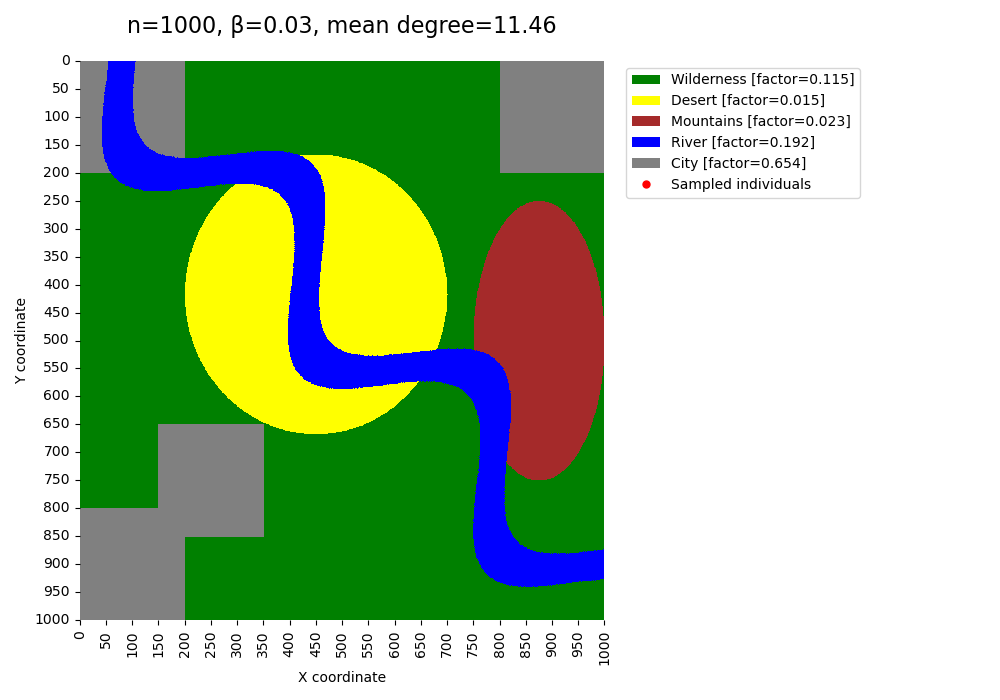

In [172]:
# Enable interactive mode
%matplotlib widget

# Generate animation
stop_animation_hook = plotAnimatedGeographicalFriendshipNetwork(n_individuals=1000, beta=0.03, n=1000, refresh_rate=500, edges_per_frame=100, individuals_per_frame=50)

# Show the animation
plt.show()